## Setup do Dataset

In [1]:
from google.colab import files

## Upload API do Kaggle -> kaggle.json

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joaoangnes","key":"b8c9a90d94797aa1a9727c6f067bbc2c"}'}

In [4]:
%pip install kaggle -q
%pip install pyarrow
%pip install fastparquet
%pip install missingno
%pip install seaborn
%pip install plotly
%pip install dask

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.0 MB/s eta 0:00:00



# US-Accident Exploratory Data Analysis
## About Dataset

Description This is a countrywide car accident dataset that covers 49 states of the USA. The accident data were collected from February 2016 to March 2023, using multiple APIs that provide streaming traffic incident (or event) data. These APIs broadcast traffic data captured by various entities, including the US and state departments of transportation, law enforcement agencies, traffic cameras, and traffic sensors within the road networks. The dataset currently contains approximately 7.7 million accident records. For more information about this dataset, please visit here.

Acknowledgements If you use this dataset, please kindly cite the following papers:

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.

Content This dataset was collected in real-time using multiple Traffic APIs. It contains accident data collected from February 2016 to March 2023 for the Contiguous United States. For more details about this dataset, please visit [here].

Inspiration The US-Accidents dataset can be used for numerous applications, such as real-time car accident prediction, studying car accident hotspot locations, casualty analysis, extracting cause and effect rules to predict car accidents, and studying the impact of precipitation or other environmental stimuli on accident occurrence. The most recent release of the dataset can also be useful for studying the impact of COVID-19 on traffic behavior and accidents.

Sampled Data (New!) For those requiring a smaller, more manageable dataset, a sampled version is available which includes 500,000 accidents. This sample is extracted from the original dataset for easier handling and analysis.

Other Details Please note that the dataset may be missing data for certain days, which could be due to network connectivity issues during data collection. Regrettably, the dataset will no longer be updated, and this version should be considered the latest.

Usage Policy and Legal Disclaimer This dataset is being distributed solely for research purposes under the Creative Commons Attribution-Noncommercial-ShareAlike license (CC BY-NC-SA 4.0). By downloading the dataset, you agree to use it only for non-commercial, research, or academic applications. If you use this dataset, it is necessary to cite the papers mentioned above.

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
%cd /content/
!kaggle datasets download sobhanmoosavi/us-accidents

/content
Dataset URL: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents
License(s): CC-BY-NC-SA-4.0
100% 651M/653M [00:10<00:00, 49.6MB/s]
100% 653M/653M [00:10<00:00, 67.5MB/s]


In [6]:
!unzip us-accidents.zip -d us-accidents

Archive:  us-accidents.zip
  inflating: us-accidents/US_Accidents_March23.csv  


In [2]:
import pandas as pd
import dask.dataframe as dd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Bonus:
Realizar um benchmarking de utilizar pandas ou dask em arquivos .csv grandes

## Amostragem de Dados para Otimização da Leitura

Uma amostra de dados foi extraída para análise dos tipos de dados das colunas e otimização da leitura do arquivo.

In [8]:
sample_df = pd.read_csv('/content/us-accidents/US_Accidents_March23.csv', nrows=100)

# Verificar os tipos de dados na amostra
sample_df.dtypes

,0
ID,object
Source,object
Severity,int64
Start_Time,object
End_Time,object
Start_Lat,float64
Start_Lng,float64
End_Lat,float64
End_Lng,float64
Distance(mi),float64


### Otimização dos Tipos de Dados para Redução do Consumo de Memória

Os tipos de dados das colunas foram otimizados para reduzir o consumo de memória durante o processamento do arquivo CSV.

In [47]:
dtype_optimized = {
    'ID': 'object',
    'Source': 'category',
    'Severity': 'int8',  # Severidade provavelmente vai de 1 a 4, então int8 é suficiente
    'Start_Time': 'float32',
    'End_Time': 'float32',
    'Start_Lat': 'float64',
    'Start_Lng': 'float64',
    'End_Lat': 'float64',
    'End_Lng': 'float64',
    'Distance(mi)': 'float32',
    'Description': 'category',
    'Street': 'category',
    'City': 'category',
    'County': 'category',
    'State': 'category',
    'Zipcode': 'category',
    'Country': 'category',
    'Timezone': 'category',
    'Airport_Code': 'category',
    'Weather_Timestamp': 'float32',
    'Temperature(F)': 'float32',
    'Wind_Chill(F)': 'float32',
    'Humidity(%)': 'float32',
    'Pressure(in)': 'float32',
    'Visibility(mi)': 'float32',
    'Wind_Direction': 'category',
    'Wind_Speed(mph)': 'float32',
    'Precipitation(in)': 'float32',
    'Weather_Condition': 'category',
    'Amenity': 'bool',
    'Bump': 'bool',
    'Crossing': 'bool',
    'Give_Way': 'bool',
    'Junction': 'bool',
    'No_Exit': 'bool',
    'Railway': 'bool',
    'Roundabout': 'bool',
    'Station': 'bool',
    'Stop': 'bool',
    'Traffic_Calming': 'bool',
    'Traffic_Signal': 'bool',
    'Turning_Loop': 'bool',
    'Sunrise_Sunset': 'category',
    'Civil_Twilight': 'category',
    'Nautical_Twilight': 'category',
    'Astronomical_Twilight': 'category'
}

### Importação do Dataset com Pandas e Processamento em Chunks

O dataset foi importado utilizando a biblioteca Pandas e o processamento foi dividido em chunks para otimizar o uso de memória.

In [15]:
import time

# Definir o tamanho de cada chunk
chunk_size = 100000

# Criar uma lista para armazenar os chunks
chunks = []

start_time = time.time()

# Iterar sobre o dataset em pedaços
for chunk in pd.read_csv('/content/us-accidents/US_Accidents_March23.csv', dtype=dtype_optimized, parse_dates=['Start_Time', 'End_Time', 'Weather_Timestamp'], chunksize=chunk_size):
    chunks.append(chunk)

# Concatenar todos os chunks em um único DataFrame
df_pandas = pd.concat(chunks)

end_time = time.time()
execution_time = end_time - start_time
print(f'Tempo de execução: {execution_time:.2f} segundos')

# Agora você pode analisar o dataset inteiro
df_pandas.head()

Tempo de execução: 349.01 segundos


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


### Importação do Dataset com Dask

O dataset foi importado utilizando a biblioteca Dask para processamento paralelo e eficiente de grandes conjuntos de dados.

In [51]:
# Ler o arquivo CSV diretamente em um DataFrame Dask
%time df_dask = dd.read_csv('/content/us-accidents/US_Accidents_March23.csv')
df_dask['Start_Time'] = dd.to_datetime(df_dask['Start_Time'], errors='coerce')
df_dask['End_Time'] = dd.to_datetime(df_dask['End_Time'], errors='coerce')
df_dask['Weather_Timestamp'] = dd.to_datetime(df_dask['Weather_Timestamp'], errors='coerce')
df_dask.head()

CPU times: user 64.9 ms, sys: 3.94 ms, total: 68.9 ms
Wall time: 211 ms


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


## Definição do Schema Parquet para Otimização do Armazenamento

Um schema Parquet foi definido utilizando a biblioteca PyArrow, com base no dicionário dtype_optimized, para garantir a otimização do tipo de dado de cada coluna durante o armazenamento dos dados no formato Parquet.

In [52]:
# Criar o schema parquet a partir do dtype_optimized
import pyarrow as pa

schema = pa.schema([
    ('ID', pa.string()),
    ('Source', pa.dictionary(pa.int8(), pa.string())),
    ('Severity', pa.int8()),
    ('Start_Time', pa.timestamp('ns')),
    ('End_Time', pa.timestamp('ns')),
    ('Start_Lat', pa.float64()),
    ('Start_Lng', pa.float64()),
    ('End_Lat', pa.float64()),
    ('End_Lng', pa.float64()),
    ('Distance(mi)', pa.float32()),
    ('Description', pa.dictionary(pa.int32(), pa.string())),
    ('Street', pa.dictionary(pa.int32(), pa.string())),
    ('City', pa.dictionary(pa.int32(), pa.string())),
    ('County', pa.dictionary(pa.int32(), pa.string())),
    ('State', pa.dictionary(pa.int8(), pa.string())),
    ('Zipcode', pa.dictionary(pa.int32(), pa.string())),
    ('Country', pa.dictionary(pa.int8(), pa.string())),
    ('Timezone', pa.dictionary(pa.int8(), pa.string())),
    ('Airport_Code', pa.dictionary(pa.int16(), pa.string())),
    ('Weather_Timestamp', pa.timestamp('ns')),
    ('Temperature(F)', pa.float32()),
    ('Wind_Chill(F)', pa.float32()),
    ('Humidity(%)', pa.float32()),
    ('Pressure(in)', pa.float32()),
    ('Visibility(mi)', pa.float32()),
    ('Wind_Direction', pa.dictionary(pa.int8(), pa.string())),
    ('Wind_Speed(mph)', pa.float32()),
    ('Precipitation(in)', pa.float32()),
    ('Weather_Condition', pa.dictionary(pa.int8(), pa.string())),
    ('Amenity', pa.bool_()),
    ('Bump', pa.bool_()),
    ('Crossing', pa.bool_()),
    ('Give_Way', pa.bool_()),
    ('Junction', pa.bool_()),
    ('No_Exit', pa.bool_()),
    ('Railway', pa.bool_()),
    ('Roundabout', pa.bool_()),
    ('Station', pa.bool_()),
    ('Stop', pa.bool_()),
    ('Traffic_Calming', pa.bool_()),
    ('Traffic_Signal', pa.bool_()),
    ('Turning_Loop', pa.bool_()),
    ('Sunrise_Sunset', pa.dictionary(pa.int8(), pa.string())),
    ('Civil_Twilight', pa.dictionary(pa.int8(), pa.string())),
    ('Nautical_Twilight', pa.dictionary(pa.int8(), pa.string())),
    ('Astronomical_Twilight', pa.dictionary(pa.int8(), pa.string())),
])

### Conversão do Dataframe para Arquivo Parquet com Dask

O dataframe foi convertido para o formato Parquet utilizando a biblioteca Dask, proporcionando melhor performance na leitura e armazenamento dos dados.

In [53]:
%time df_dask.to_parquet('/content/us-accidents/US_Accidents_March23.parquet.gzip', schema=schema, compression='gzip', engine='pyarrow')

CPU times: user 5min 32s, sys: 25.9 s, total: 5min 58s
Wall time: 4min 32s


### Leitura do Arquivo Parquet com Dask utilizando

Foi realizado um benchmark para comparar a performance da leitura do arquivo Parquet com Dask utilizando as engines 'pyarrow' e 'fastparquet'.

Os resultados indicaram que a engine 'fastparquet' apresentou melhor performance em termos de tempo de leitura.

In [7]:
# Ler o arquivo Parquet com Dask
%time df_parquet_dask = dd.read_parquet('/content/us-accidents/US_Accidents_March23.parquet.gzip', engine='pyarrow')

# Exibir as primeiras linhas do DataFrame
df_parquet_dask.head()

CPU times: user 65.1 ms, sys: 1.15 ms, total: 66.2 ms
Wall time: 177 ms


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [5]:
# Ler o arquivo Parquet com Dask
%time df_parquet_dask = dd.read_parquet('/content/us-accidents/US_Accidents_March23.parquet.gzip', engine='fastparquet')

# Exibir as primeiras linhas do DataFrame
df_parquet_dask.head()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/io/parquet/core.py:1241: FutureWarning: The fastparquet engine is deprecated and will be removed in a future release. Please install pyarrow.
  warnings.warn(


CPU times: user 31 ms, sys: 72 µs, total: 31.1 ms
Wall time: 41.1 ms


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


### Leitura do Arquivo Parquet com Pandas utilizando

Foi realizado um benchmark para comparar a performance da leitura do arquivo Parquet com Pandas utilizando as engines 'pyarrow' e 'fastparquet'.

Os resultados indicaram que com a engine 'fastparquet' foi possivel ler os arquivos com a memoria padrão, porém com 'pyarrow' não foi possível.

In [ ]:
# Ler o arquivo Parquet com Pandas
%time df_parquet_pandas = pd.read_parquet('/content/us-accidents/US_Accidents_March23.parquet.gzip', engine='pyarrow')

# Exibir as primeiras linhas do DataFrame
df_parquet_pandas.head()

In [3]:
# Ler o arquivo Parquet com Pandas
%time df_parquet_pandas = pd.read_parquet('/content/us-accidents/US_Accidents_March23.parquet.gzip', engine='fastparquet')

# Exibir as primeiras linhas do DataFrame
df_parquet_pandas.head()

CPU times: user 15.3 s, sys: 4.32 s, total: 19.6 s
Wall time: 28.3 s


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


### Analise do Dataset
### Tarefas:

[1] - Limpeza de Dados: Preparar os dados, eliminando duplicatas e preenchendo valores faltantes.

[2] - Análise Exploratória: Usar seaborn para identificar correlações e padrões entre os acidentes e as variáveis disponíveis.

[3] - Visualizações Interativas: Criar gráficos interativos com plotly, como mapas interativos para mostrar onde os acidentes mais graves ocorrem.

[4] - Análise Temporal: Usar heatmaps de tempo para identificar em quais horários ou dias da semana os acidentes são mais frequentes.

In [10]:
%time df_parquet_pandas.shape

CPU times: user 25 µs, sys: 5 µs, total: 30 µs
Wall time: 34.8 µs


(7728394, 46)

In [11]:
%time df_parquet_dask.shape

CPU times: user 7.5 ms, sys: 98 µs, total: 7.6 ms
Wall time: 7.63 ms


(Delayed('int-65b320ac-14cc-4b6e-929c-3d4c5f35e90a'), 46)

In [12]:
%time df_parquet_pandas.columns

CPU times: user 21 µs, sys: 4 µs, total: 25 µs
Wall time: 29.8 µs


Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [13]:
%time df_parquet_dask.columns

CPU times: user 30 µs, sys: 6 µs, total: 36 µs
Wall time: 40.5 µs


Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [14]:
%time df_parquet_pandas.describe()

CPU times: user 4.74 s, sys: 1.66 s, total: 6.4 s
Wall time: 6.59 s


,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,7.728394e+06,6561021,6561021,7.728394e+06,7.728394e+06,4.325632e+06,4.325632e+06,7.728394e+06,7608166,7.564541e+06,5.729375e+06,7.554250e+06,7.587715e+06,7.551296e+06,7.157161e+06,5.524808e+06
mean,2.212384e+00,2020-02-15 21:54:38.144122112,2020-02-16 04:00:33.184194816,3.620119e+01,-9.470255e+01,3.626183e+01,-9.572557e+01,5.618424e-01,2020-06-02 10:06:41.888673280,6.166328e+01,5.825107e+01,6.483104e+01,2.953897e+01,9.090379e+00,7.685486e+00,8.407206e-03
min,1.000000e+00,2016-01-14 20:18:33,2016-02-08 06:37:08,2.455480e+01,-1.246238e+02,2.456601e+01,-1.245457e+02,0.000000e+00,2016-01-14 19:51:00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,2018-08-03 17:22:12,2018-08-03 19:02:12,3.339963e+01,-1.172194e+02,3.346207e+01,-1.177543e+02,0.000000e+00,2018-11-20 18:35:00,4.900000e+01,4.300000e+01,4.800000e+01,2.937000e+01,1.000000e+01,4.600000e+00,0.000000e+00
50%,2.000000e+00,2020-04-15 00:18:30,2020-04-15 05:35:28,3.582397e+01,-8.776662e+01,3.618349e+01,-8.802789e+01,3.000000e-02,2020-11-10 13:53:00,6.400000e+01,6.200000e+01,6.700000e+01,2.986000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,2021-10-14 17:07:45,2021-10-15 08:53:30,4.008496e+01,-8.035368e+01,4.017892e+01,-8.024709e+01,4.640000e-01,2022-01-19 14:27:00,7.600000e+01,7.500000e+01,8.400000e+01,3.003000e+01,1.000000e+01,1.040000e+01,0.000000e+00
max,4.000000e+00,2023-03-31 23:30:00,2023-03-31 23:59:00,4.900220e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,4.417500e+02,2023-03-31 23:53:00,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,3.647000e+01
std,4.875313e-01,NaN,NaN,5.076079e+00,1.739176e+01,5.272905e+00,1.810793e+01,1.746904e+00,NaN,1.892446e+01,2.227578e+01,2.272380e+01,1.969328e+00,2.817147e+00,5.364744e+00,1.098671e-01


In [15]:
%time df_parquet_dask.describe().compute()

CPU times: user 19.7 s, sys: 497 ms, total: 20.2 s
Wall time: 20.8 s


,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,7.728394e+06,6561021,6561021,7.728394e+06,7.728394e+06,4.325632e+06,4.325632e+06,7.728394e+06,7608166,7.564541e+06,5.729375e+06,7.554250e+06,7.587715e+06,7.551296e+06,7.157161e+06,5.524808e+06
min,1.000000e+00,2016-01-14 20:18:33,2016-02-08 06:37:08,2.455480e+01,-1.246238e+02,2.456601e+01,-1.245457e+02,0.000000e+00,2016-01-14 19:51:00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,2018-09-28 07:55:52,2018-09-21 13:51:03.500000,3.403100e+01,-9.785238e+01,3.403112e+01,-1.171213e+02,0.000000e+00,2018-12-28 04:38:00,5.700000e+01,5.400000e+01,5.700000e+01,2.969000e+01,1.000000e+01,5.800000e+00,0.000000e+00
50%,2.000000e+00,2020-05-23 09:23:48,2020-07-26 17:28:06.249999872,3.903448e+01,-8.476065e+01,3.903322e+01,-8.501319e+01,1.390000e-01,2020-12-11 02:55:00,7.000000e+01,7.000000e+01,7.600000e+01,2.996000e+01,1.000000e+01,8.100000e+00,0.000000e+00
75%,3.000000e+00,2021-11-09 17:42:46.500000,2022-02-17 22:26:49,4.224331e+01,-8.004351e+01,4.224285e+01,-8.004272e+01,1.078000e+00,2022-04-15 08:54:00,8.600000e+01,8.600000e+01,8.900000e+01,3.030000e+01,1.000000e+01,1.200000e+01,5.000000e-02
max,4.000000e+00,2023-03-31 23:30:00,2023-03-31 23:59:00,4.900220e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,4.417500e+02,2023-03-31 23:53:00,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,3.647000e+01
mean,2.212384e+00,<NA>,<NA>,3.620119e+01,-9.470255e+01,3.626183e+01,-9.572557e+01,5.618423e-01,<NA>,6.166329e+01,5.825104e+01,6.483104e+01,2.953899e+01,9.090377e+00,7.685489e+00,8.407210e-03
std,4.875313e-01,<NA>,<NA>,5.076079e+00,1.739176e+01,5.272905e+00,1.810793e+01,1.776811e+00,<NA>,1.901365e+01,2.238983e+01,2.282097e+01,1.006190e+00,2.688316e+00,5.424984e+00,1.102246e-01


### Análise - [1] Limpeza de Dados

*   Identificação e tratamento de valores ausentes no dataset.

### Processamento com Dask Dataframe

A performance do processamento com o Dask Dataframe não foi satisfatória, levando aproximadamente 1 minuto para executar o bloco de código.

In [6]:
missing_data = df_parquet_dask.isnull().sum()
data_types = df_parquet_dask.dtypes

missing_data_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Data Type': data_types
})

missing_data_df.sort_values(ascending = False, by='Missing Values')

,Missing Values,Data Type
End_Lng,3402762,float64
End_Lat,3402762,float64
Precipitation(in),2203586,float32
Wind_Chill(F),1999019,float32
Start_Time,1167373,datetime64[ns]
End_Time,1167373,datetime64[ns]
Wind_Speed(mph),571233,float32
Visibility(mi),177098,float32
Wind_Direction,175206,object
Humidity(%),174144,float32


### Processamento com Pandas Dataframe

O processamento com o Pandas Dataframe apresentou performance significativamente superior, executando o bloco de código em apenas 10 segundos.

In [17]:
missing_data = df_parquet_pandas.isnull().sum()
data_types = df_parquet_pandas.dtypes

missing_data_df = pd.DataFrame({
    'Missing Values': missing_data,
    'Data Type': data_types
})

missing_data_df.sort_values(ascending = False, by='Missing Values')

,Missing Values,Data Type
End_Lng,3402762,float64
End_Lat,3402762,float64
Precipitation(in),2203586,float32
Wind_Chill(F),1999019,float32
Start_Time,1167373,datetime64[ns]
End_Time,1167373,datetime64[ns]
Wind_Speed(mph),571233,float32
Visibility(mi),177098,float32
Wind_Direction,175206,object
Humidity(%),174144,float32


## Observação

A partir deste ponto, utilizaremos apenas o DataFrame do Pandas para análise, uma vez que ele se mostrou superior nas execuções de análise.

## Resultado do Benchmark

Ao ler um arquivo CSV grande, a biblioteca Dask se destaca em termos de desempenho, conseguindo realizar toda a leitura em segundos. Isso se deve ao uso de técnicas de paralelismo pela biblioteca.

Por outro lado, o Pandas enfrenta dificuldades na leitura do arquivo, exigindo a especificação dos tipos de colunas e a separação em chunks. Isso ocorre porque o Pandas precisa carregar todo o conjunto de dados na memória para processá-lo, o que pode gerar problemas de memória. Em ambientes comuns, como o Google Colab, isso pode resultar em estourar o limite de memória.

## Leitura de Arquivo Parquet

Dask também se mostra superior na performance de leitura de arquivos Parquet, independentemente da engine utilizada (['pyarrow', 'fastparquet']).

O Pandas tem um desempenho inferior ao usar a engine 'pyarrow', mas apresenta resultados mais aceitáveis ao utilizar 'fastparquet'.

## Manipulação do DataFrame Parquet

Neste aspecto, percebi que o Dask pode criar um gargalo de desempenho, levando mais tempo para executar algumas tarefas em comparação ao Pandas.

## Conclusão

Para leitura e gravação de arquivos, Dask demonstrou um desempenho muito superior em ambientes com memória RAM limitada (como o Google Colab comum, que possui 12 GB). No entanto, para a manipulação do DataFrame e análise de dados, o Pandas se mostrou mais eficiente.

## Porcentagem de Valores Nulos em Cada Coluna

Observamos uma concentração significativa de dados faltantes nas seguintes colunas:

- **End_Lng**: Mostra a longitude em coordenadas GPS do ponto final.
- **End_Lat**: Mostra a latitude em coordenadas GPS do ponto final.
- **Precipitation(in)**: Indica a quantidade de precipitação em polegadas, se houver.
- **Wind_Chill(F)**: Refere-se à sensação térmica do vento (em Fahrenheit).
- **Wind_Speed(mph)**: Representa a velocidade do vento em milhas por hora.

As demais variáveis não apresentam uma quantidade expressiva de dados faltantes.

<Axes: >

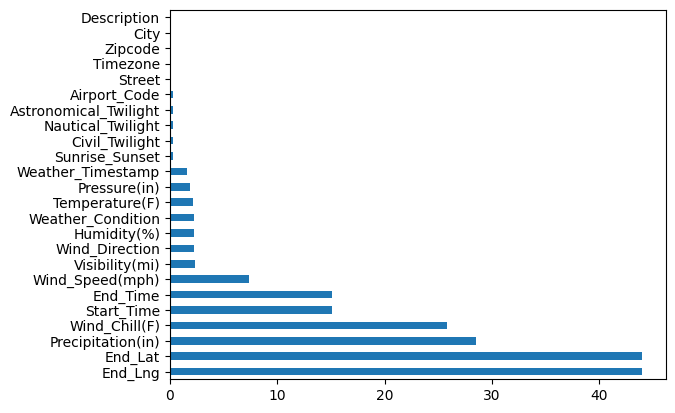

In [7]:
missing_percentage = df_parquet_pandas.isna().sum().sort_values(ascending = False) / len(df_parquet_pandas) * 100
missing_percentage[missing_percentage != 0].plot(kind="barh")

<Axes: >

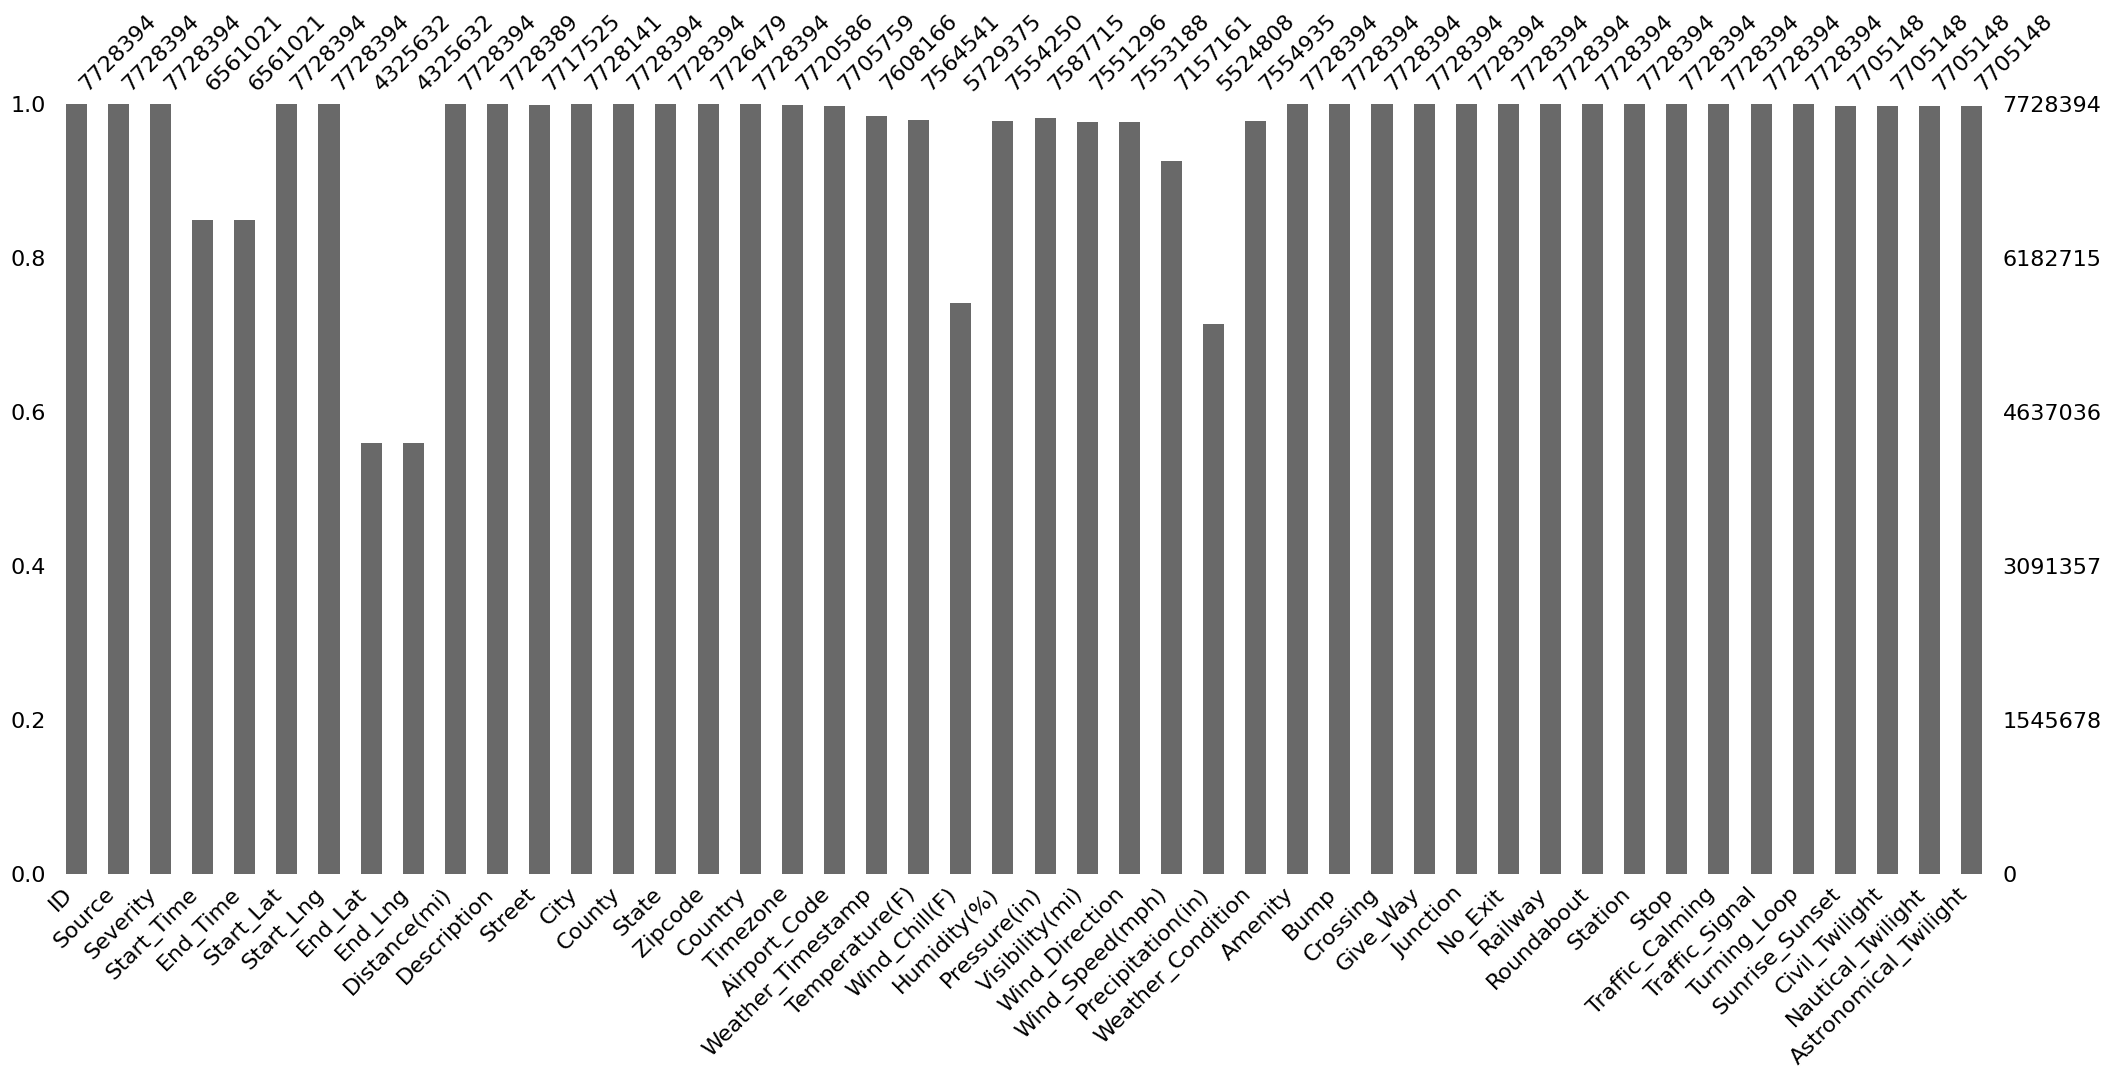

In [19]:
msno.bar(df_parquet_pandas)

## Descrição do Bloco de Código

Este bloco de código contém duas funções principais: `estatisticas_numericas` e `comparacao`, que juntas realizam análises estatísticas e visuais de uma coluna específica de um DataFrame do Pandas.

### Função `estatisticas_numericas(df, coluna)`

A função `estatisticas_numericas` calcula e imprime as principais estatísticas descritivas para uma coluna numérica de um DataFrame fornecido. As estatísticas calculadas incluem:

- **Média**: O valor médio da coluna, que representa o centro dos dados.
- **Mediana**: O valor central da coluna, que divide os dados em duas metades.
- **Moda**: O valor mais frequente na coluna, que indica a tendência mais comum nos dados.
- **Desvio Padrão**: Uma medida da dispersão dos dados em relação à média, que indica a variabilidade dos valores.

Essas estatísticas são impressas no console para fácil análise.

### Função `comparacao(col)`

A função `comparacao` realiza uma análise visual dos valores únicos de uma coluna específica, criando três gráficos diferentes:

1. **Histograma**: Um gráfico que mostra a distribuição dos dados, permitindo visualizar a densidade dos valores. O método `histplot` da biblioteca Seaborn é utilizado para incluir a estimativa de densidade de kernel (KDE).
   
2. **BoxPlot**: Um gráfico que resume as estatísticas descritivas, incluindo os quartis, e destaca os outliers. O BoxPlot é útil para identificar a dispersão e possíveis anomalias nos dados.

3. **ViolinPlot**: Um gráfico que combina informações do BoxPlot e da densidade de probabilidade dos dados. Ele fornece uma representação visual mais rica, mostrando a distribuição dos dados em diferentes valores.

O layout dos gráficos é ajustado usando `gridspec` para melhor visualização. O título de cada gráfico é definido com base na coluna analisada, e o layout final é otimizado com `plt.tight_layout()`.

Por fim, a função `estatisticas_numericas` é chamada para imprimir as estatísticas descritivas da coluna analisada, proporcionando uma visão abrangente dos dados, tanto em termos estatísticos quanto visuais.

In [20]:
# Calcular estatísticas descritivas
def estatisticas_numericas(df, coluna):
    media = df[coluna].mean()
    mediana = df[coluna].median()
    moda = df[coluna].mode()[0]
    desvio_padrao = df[coluna].std()

    print(f"Estatísticas de {coluna}:")
    print(f"Média: {media}")
    print(f"Mediana: {mediana}")
    print(f"Moda: {moda}")
    print(f"Desvio Padrão: {desvio_padrao}")

def comparacao(col):
  x = df_parquet_pandas[col].unique() # Valores unicos
  title = col
  sb.set(style='whitegrid')

  # Aumentando o tamanho da figura e usando gridspec para ajustar a altura dos gráficos
  fig = plt.figure(figsize=(12, 15))
  gs = fig.add_gridspec(3, 1)

  # Histogram
  ax1 = fig.add_subplot(gs[0, 0])
  sb.histplot(x, ax=ax1, kde=True)  # Substituir distplot por histplot
  ax1.set_title('Histogram')

  # BoxPlot
  ax2 = fig.add_subplot(gs[1, 0])
  sb.boxplot(x=x, ax=ax2, color='lightblue')
  ax2.set_title('BoxPlot')

  # ViolinPlot
  ax3 = fig.add_subplot(gs[2, 0])
  sb.violinplot(x=x, ax=ax3, inner='quartile', color='lightgreen')
  ax3.set_title('ViolinPlot')

  # Ajustar o título da figura
  fig.suptitle(title, fontsize=16)

  plt.tight_layout()  # Melhora o layout
  plt.show()
  estatisticas_numericas(df_parquet_pandas, col)

## Análise da Coluna End_Lng

A análise da coluna **End_Lng** (longitude do ponto final) revela uma **distribuição assimétrica**, caracterizada por uma quantidade significativa de **outliers**. Esses outliers indicam a presença de valores extremos que se afastam da maioria dos dados.

Além disso, a distribuição não apresenta **concentrações significativas** de dados em um único local, sugerindo que as longitudes estão distribuídas de maneira ampla, sem um padrão claro em termos de agrupamento geográfico.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


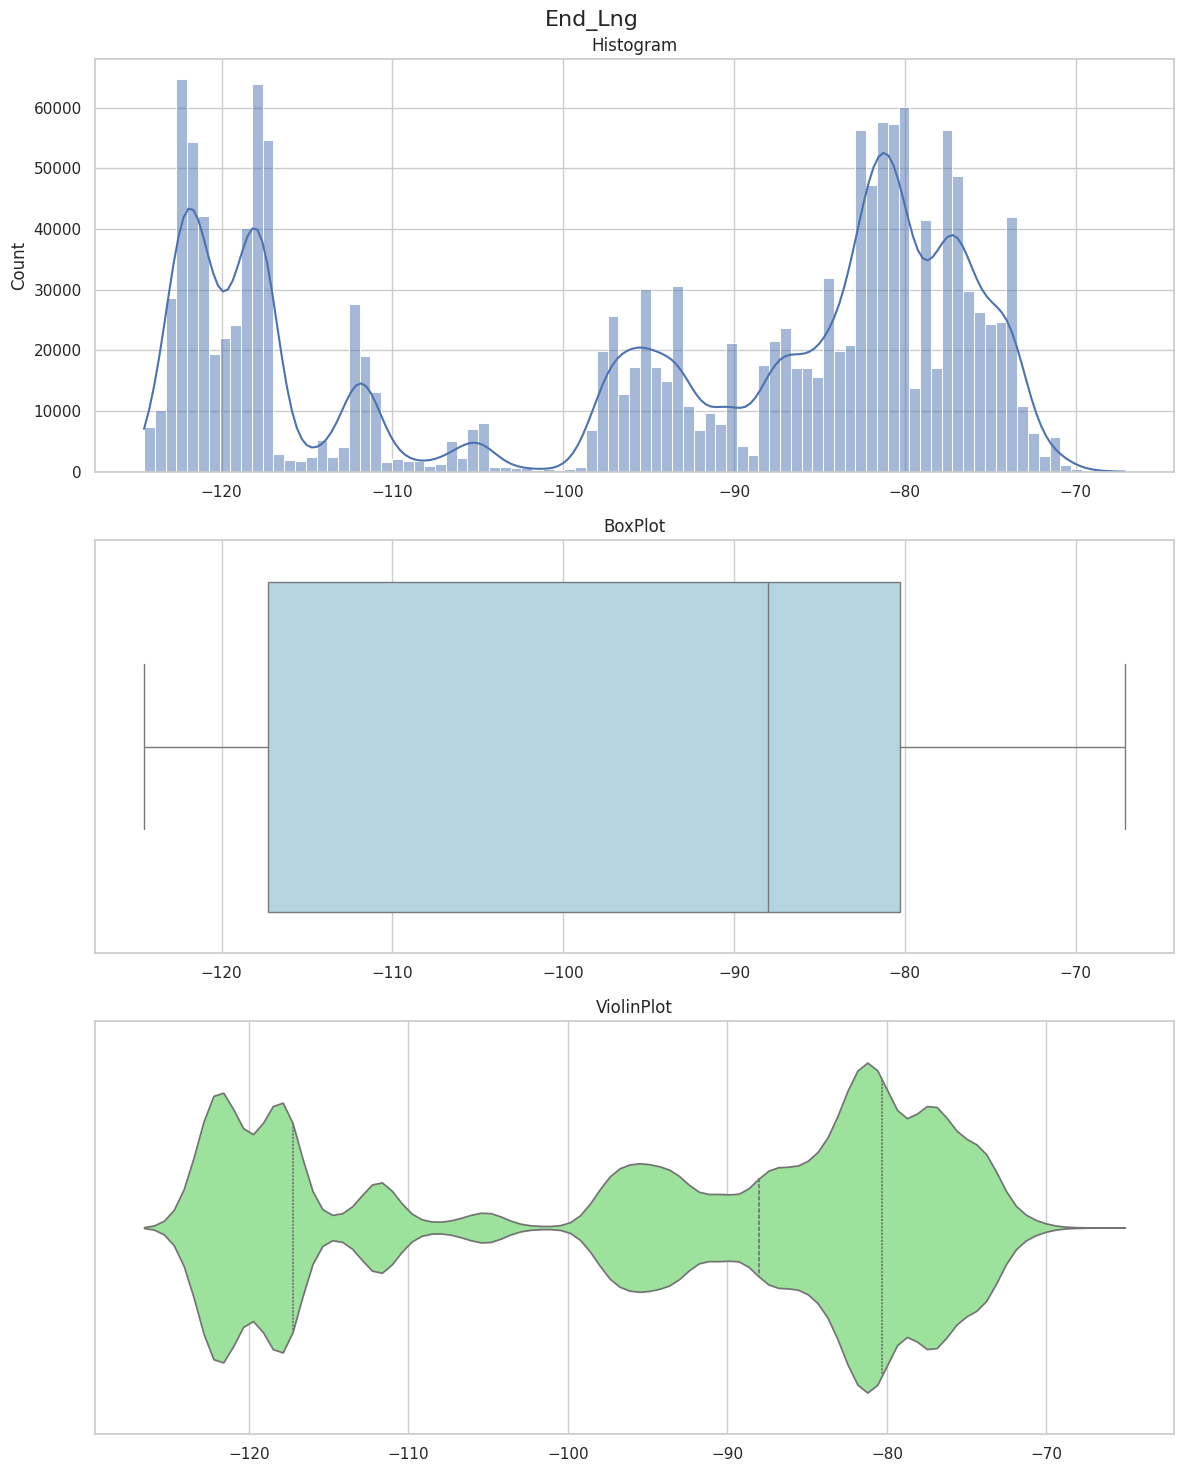

Estatísticas de End_Lng:
Média: -95.72557026006888
Mediana: -88.02789000000001
Moda: -81.471375
Desvio Padrão: 18.1079276362948


In [21]:
col = 'End_Lng'
comparacao(col)

## Análise da Coluna End_Lat

A análise da coluna **End_Lat** (latitude do ponto final) revela uma **distribuição assimétrica**, com a presença de **poucos outliers**. Isso sugere que a maioria dos valores está concentrada em torno de um intervalo específico, com menos desvios extremos em comparação com outras variáveis.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


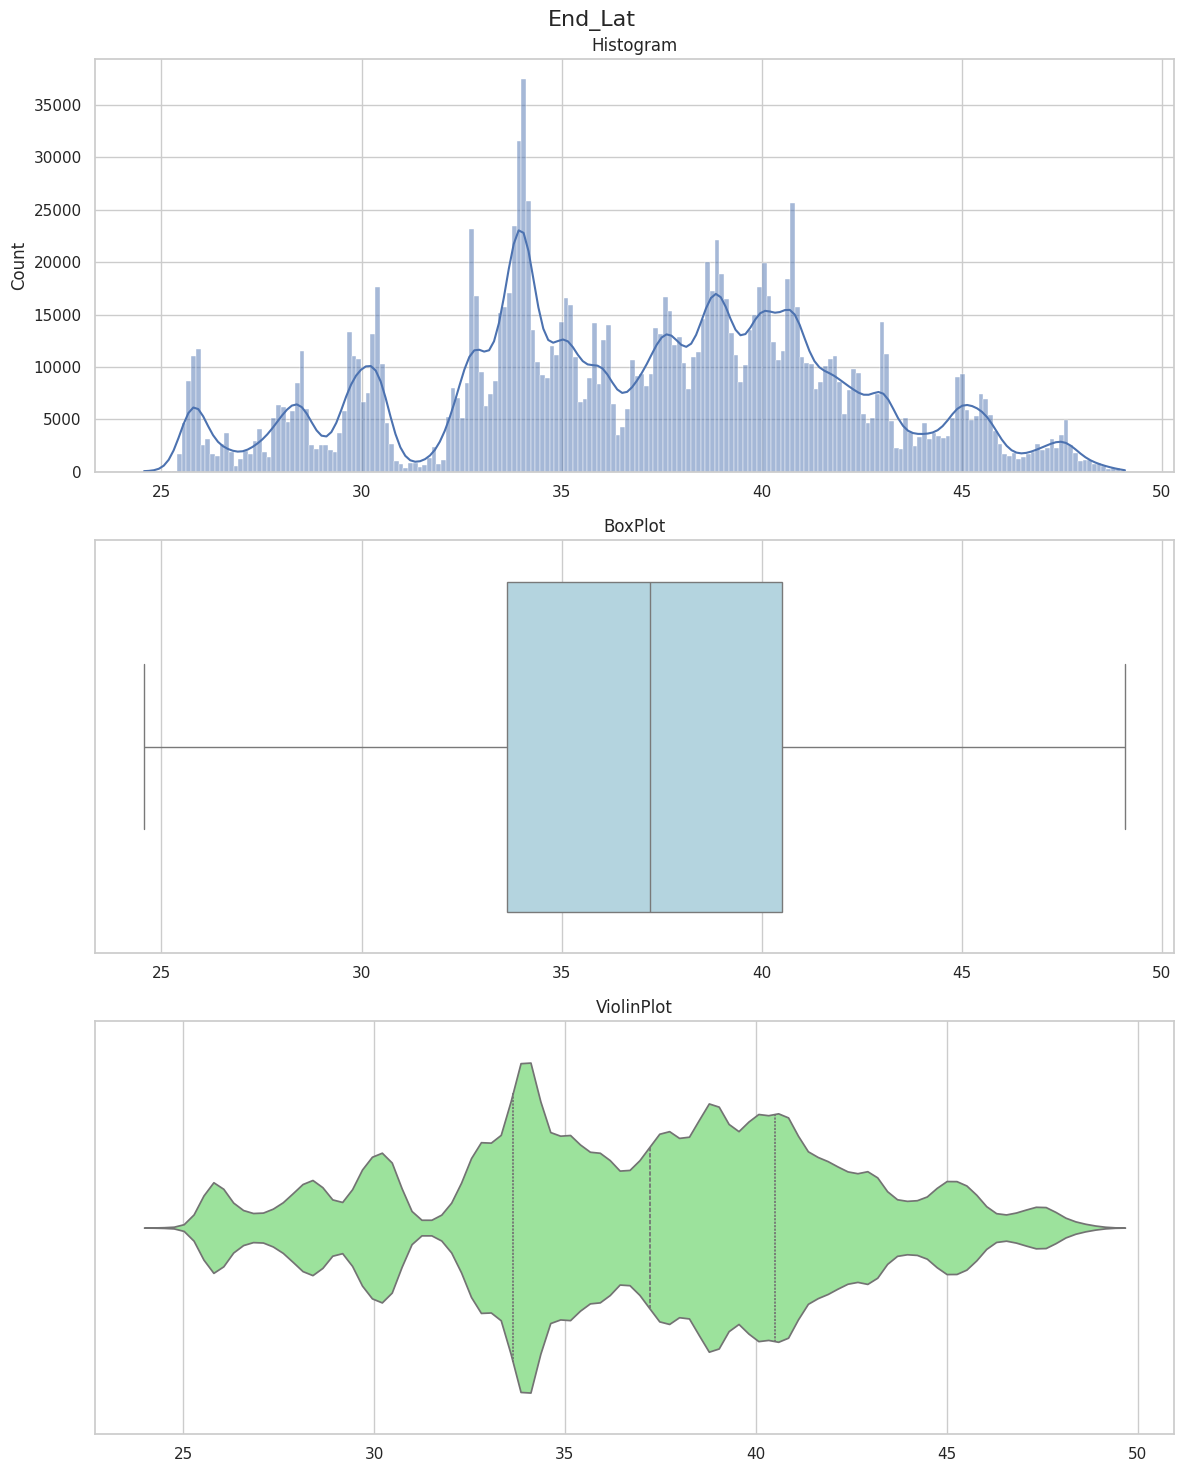

Estatísticas de End_Lat:
Média: 36.26182889162044
Mediana: 36.18349450000001
Moda: 28.450015000000004
Desvio Padrão: 5.272904539384569


In [22]:
col = 'End_Lat'
comparacao(col)

## Análise da Coluna Wind_Chill(F)

A análise da coluna **Wind_Chill(F)** (sensação térmica do vento em Fahrenheit) revela uma **distribuição assimétrica**, com a presença de **alguns outliers**. Observamos que existe uma **grande concentração de dados** na faixa de valores entre **-40 e 40** graus Fahrenheit.

Dada a distribuição observada, propomos a utilização da **mediana** para substituir os valores faltantes. Essa abordagem é preferível, pois a mediana é menos afetada por valores extremos, garantindo uma estimativa mais robusta da tendência central.

Além disso, poderíamos considerar a utilização da **moda** para a imputação de valores faltantes, uma vez que há uma **significativa concentração de dados** em torno de determinados valores.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


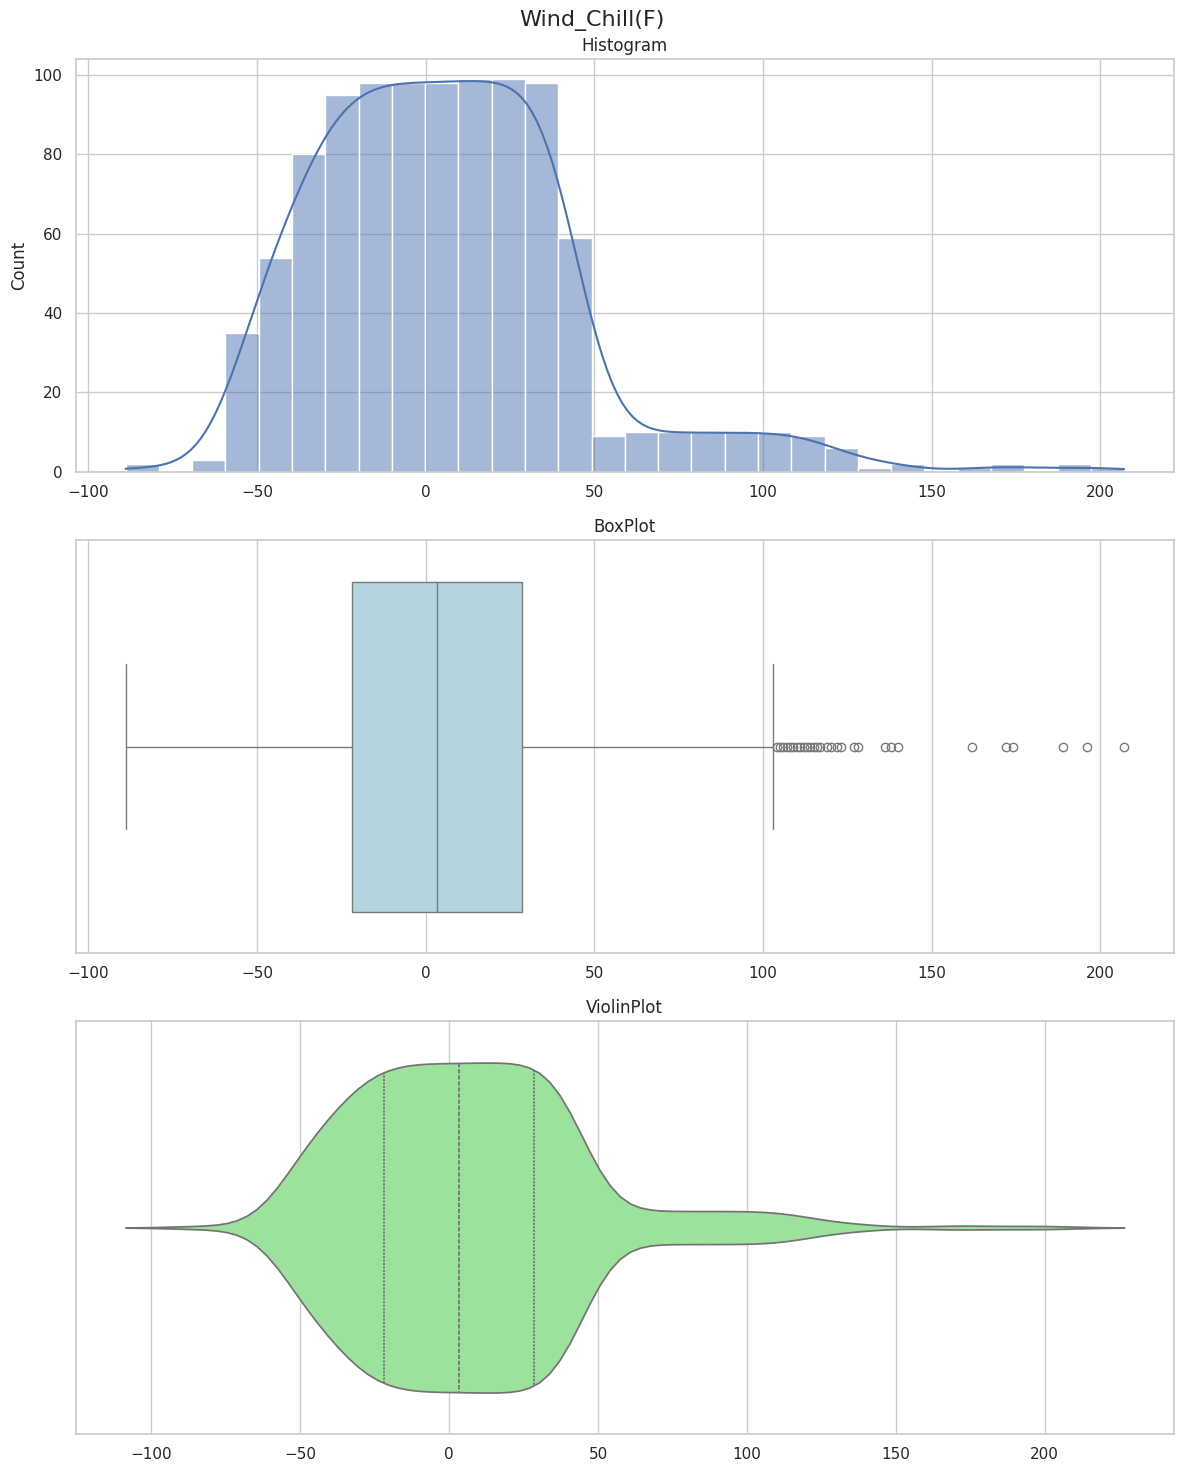

Estatísticas de Wind_Chill(F):
Média: 58.25107192993164
Mediana: 62.0
Moda: 73.0
Desvio Padrão: 22.27578353881836


In [23]:
col = 'Wind_Chill(F)'
comparacao(col)

## Análise da Coluna Wind_Speed(mph)

A análise da coluna **Wind_Speed(mph)** (velocidade do vento em milhas por hora) revela uma **distribuição assimétrica** com uma **concentração à esquerda**. A presença de **outliers** é notada, especialmente na **longa cauda à direita**, conforme mostrado nos gráficos de **histograma** e **violin plot**.

Dada a distribuição observada, propomos a utilização da **mediana** para substituir os valores faltantes. Essa escolha é vantajosa, pois a mediana é menos suscetível à influência de valores extremos, proporcionando uma estimativa mais confiável da tendência central da variável.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


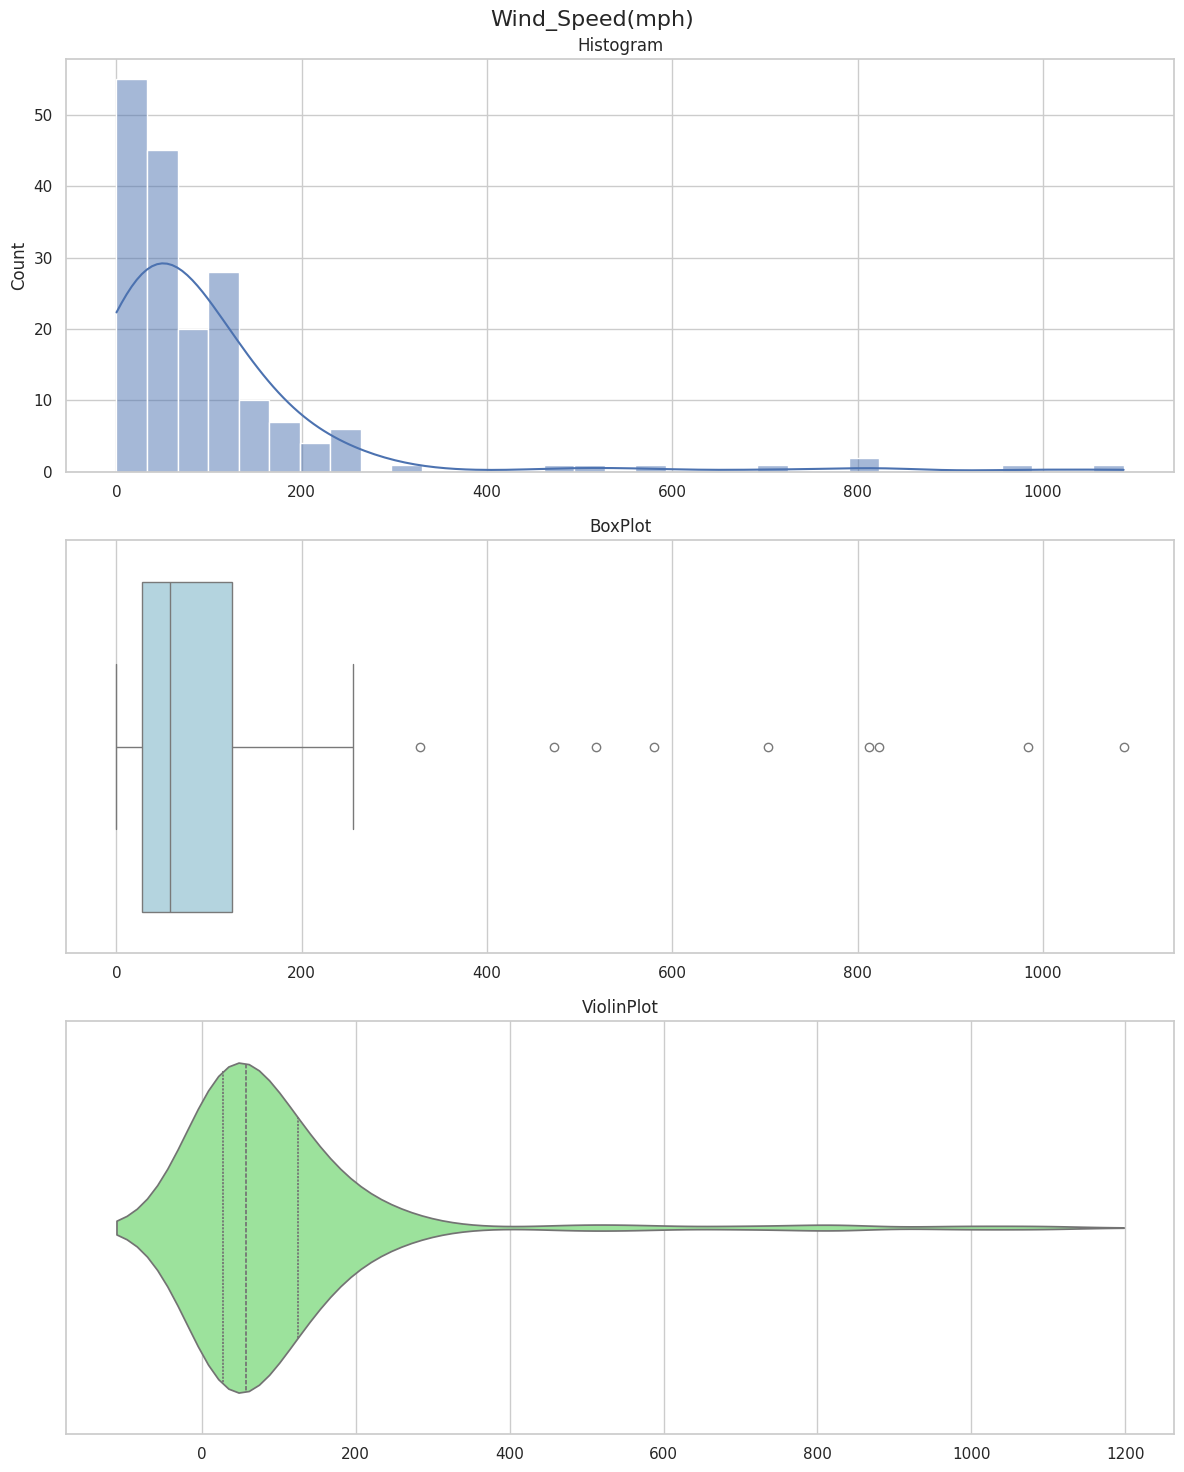

Estatísticas de Wind_Speed(mph):
Média: 7.68548583984375
Mediana: 7.0
Moda: 0.0
Desvio Padrão: 5.364744186401367


In [24]:
col = 'Wind_Speed(mph)'
comparacao(col)

## Tratamento dos Dados Nulos

### Variáveis Mais Relevantes

#### Numéricas
Para as variáveis numéricas com dados faltantes, utilizaremos a **mediana** da coluna para o tratamento dos dados. As variáveis em questão são:
- **Precipitation(in)**: Quantidade de precipitação em polegadas.
- **Wind_Chill(F)**: Sensação térmica do vento em Fahrenheit.
- **Wind_Speed(mph)**: Velocidade do vento em milhas por hora.

No caso das variáveis de **latitude** e **longitude**, decidimos mantê-las como nulas. Essa abordagem é adotada para evitar comprometer a análise geográfica. Durante a análise dos locais dos acidentes, será necessário desconsiderar os registros que apresentem latitudes ou longitudes nulas.

### Variáveis Menos Relevantes

Para as variáveis consideradas menos relevantes, adotaremos as seguintes estratégias de tratamento para os dados faltantes:
- **Numéricas**: Utilizaremos a **mediana** da coluna para o tratamento dos dados.
- **Categóricas**: Alteraremos os dados faltantes para a categoria **'Desconhecido'**, para garantir que os registros permaneçam completos.

In [8]:
def tratar_dados(df):
    # Variáveis Relevantes
    # Preencher variáveis relevantes numéricas com a mediana
    df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Precipitation(in)'].median())
    df['Wind_Chill(F)'] = df['Wind_Chill(F)'].fillna(df['Wind_Chill(F)'].median())
    df['Wind_Speed(mph)'] = df['Wind_Speed(mph)'].fillna(df['Wind_Speed(mph)'].median())

    cols_sem_tratamento = ['End_Lng', 'Start_Lng', 'Start_Lat', 'End_Lat']

    # Variáveis Relevantes - Preencher variáveis numéricas com a mediana, exceto nas colunas a serem ignoradas
    for col in df.columns:
        if col not in cols_sem_tratamento and df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(df[col].median())

    # Variáveis Menos Relevantes - Preencher as variáveis categóricas com 'Unknown',  exceto nas colunas a serem ignoradas
    for col in df.columns:
        if col not in cols_sem_tratamento and df[col].dtype in ['object', 'string', 'category']:
          df[col] = df[col].fillna('Unknown')

    return df

## Resultado do Tratamento de Valores Nulos

Conforme apresentado, o problema de valores nulos no dataset foi resolvido, com exceção das colunas de coordenadas.

<Axes: >

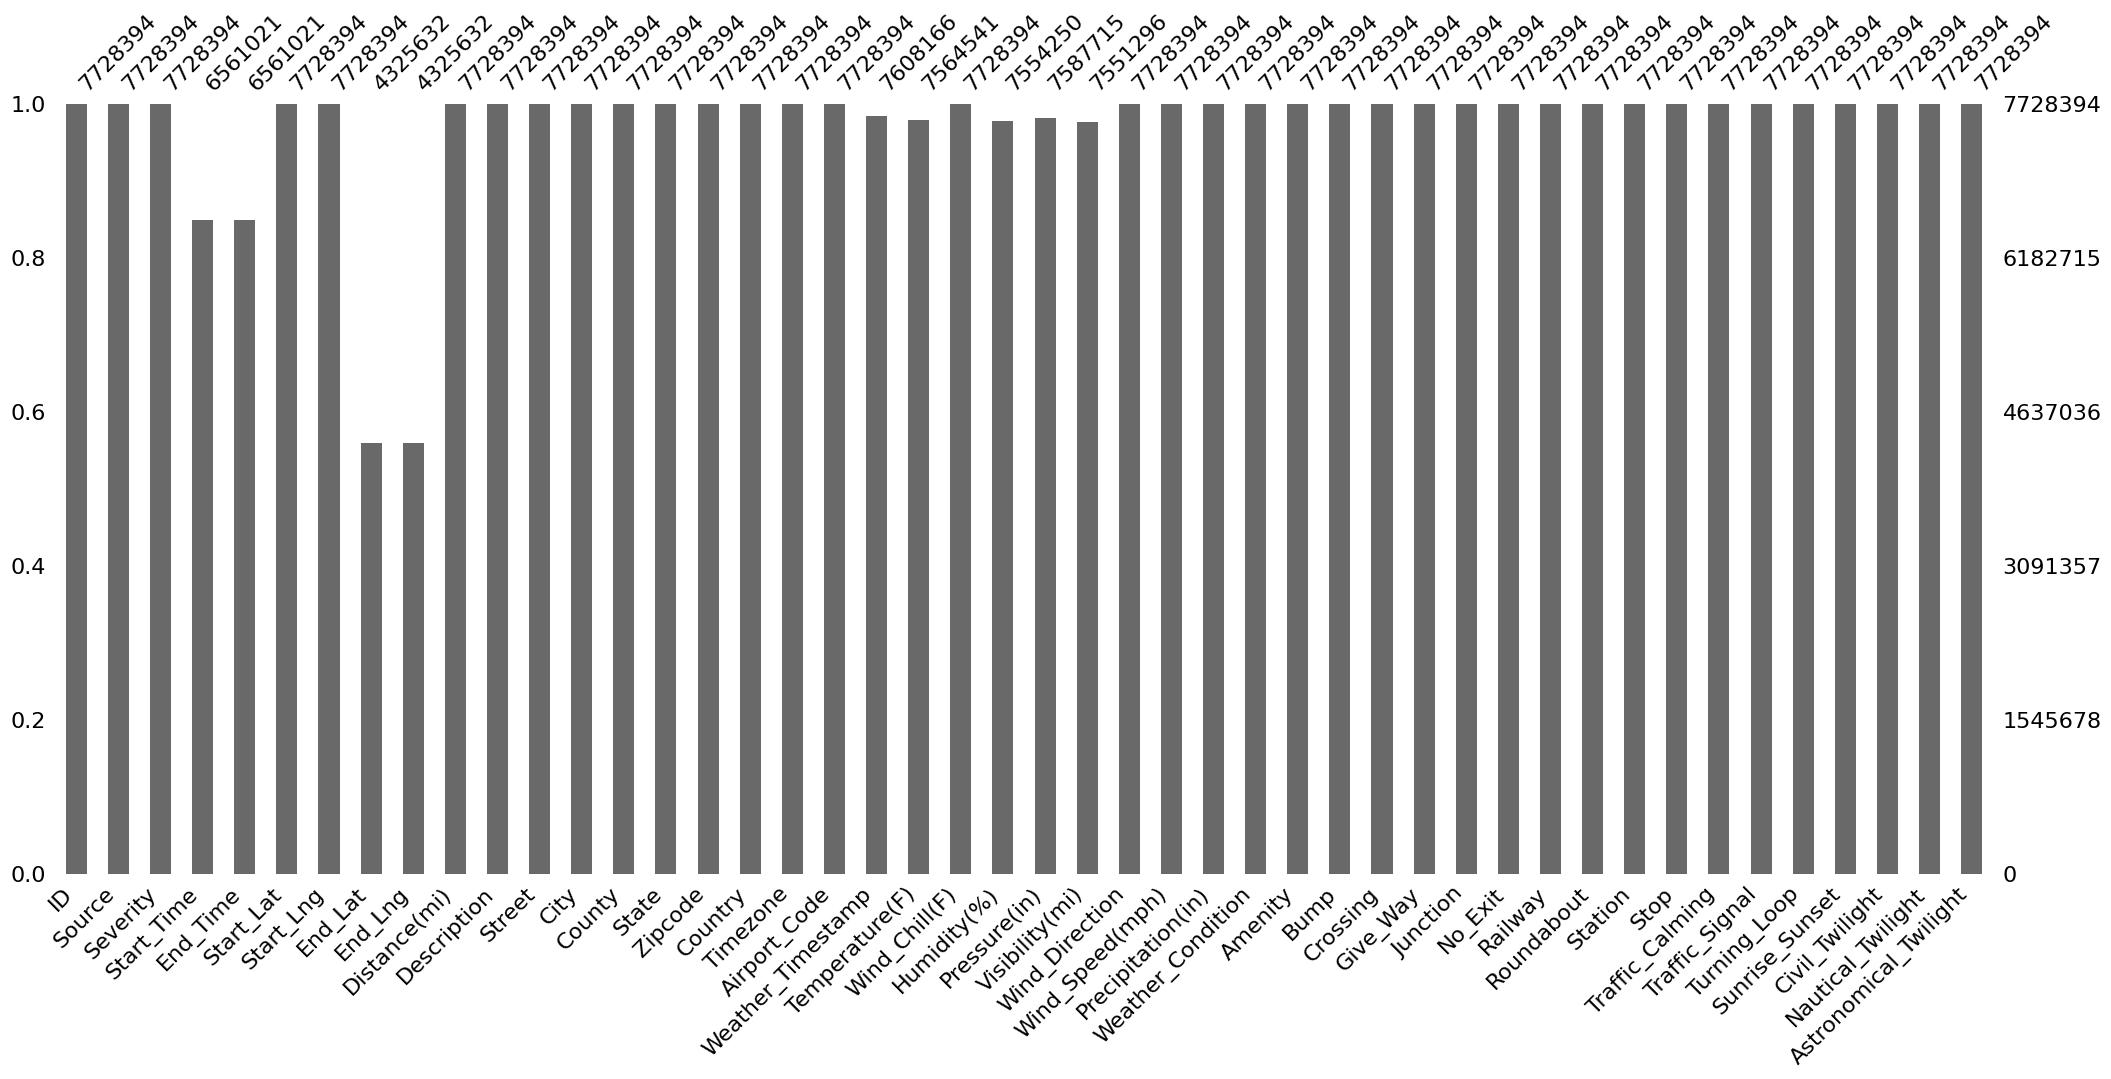

In [9]:
# Aplicar a função ao DataFrame principal
df_parquet_pandas_nan_clean = tratar_dados(df_parquet_pandas)

msno.bar(df_parquet_pandas_nan_clean)

## Análise Exploratória

### Identificação de Correlações e Padrões

Nesta seção, realizaremos uma análise exploratória para identificar correlações e padrões entre os acidentes e as variáveis disponíveis no dataset.

O objetivo é compreender como diferentes fatores podem influenciar a ocorrência e a gravidade dos acidentes.


In [27]:
df_numeric = df_parquet_pandas.select_dtypes(include=[float, int])
corr_matrix = df_numeric.corr()
corr_matrix

,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
Start_Lat,1.000000,-0.067720,0.999993,-0.121743,0.064064,-0.443781,-0.422355,0.022364,-0.194094,-0.088500,0.031512,-0.000136
Start_Lng,-0.067720,1.000000,-0.121735,0.999999,0.007851,-0.010652,-0.031156,0.179500,0.193185,-0.015322,0.075136,0.025601
End_Lat,0.999993,-0.121735,1.000000,-0.121732,0.067932,-0.468692,-0.459587,0.027849,-0.242143,-0.116199,0.016188,-0.005217
End_Lng,-0.121743,0.999999,-0.121732,1.000000,0.005876,0.024084,0.004800,0.167428,0.216028,0.006155,0.090274,0.025850
Distance(mi),0.064064,0.007851,0.067932,0.005876,1.000000,-0.054082,-0.047256,0.008780,-0.093121,-0.037225,0.009332,0.002032
Temperature(F),-0.443781,-0.010652,-0.468692,0.024084,-0.054082,1.000000,0.913717,-0.330939,0.109500,0.217173,0.033959,-0.004920
Wind_Chill(F),-0.422355,-0.031156,-0.459587,0.004800,-0.047256,0.913717,1.000000,-0.272632,0.103171,0.203309,-0.033754,-0.003473
Humidity(%),0.022364,0.179500,0.027849,0.167428,0.008780,-0.330939,-0.272632,1.000000,0.115573,-0.384261,-0.169139,0.068013
Pressure(in),-0.194094,0.193185,-0.242143,0.216028,-0.093121,0.109500,0.103171,0.115573,1.000000,0.038161,-0.025614,0.003837
Visibility(mi),-0.088500,-0.015322,-0.116199,0.006155,-0.037225,0.217173,0.203309,-0.384261,0.038161,1.000000,0.014734,-0.105315


## Análise de Correlação Numérica

Durante a análise de correlação entre as variáveis numéricas do dataset, não foi possível identificar correlações significativas com as possíveis causas de acidentes.

### Observações:

* As variáveis numéricas não mostraram padrões ou relações claras que pudessem indicar um impacto direto na ocorrência de acidentes.
* É importante considerar que a ausência de correlações não significa que não haja fatores relevantes; pode indicar a necessidade de explorar variáveis adicionais ou realizar análises mais profundas.

Essa análise ressalta a complexidade da relação entre as variáveis e os acidentes, sugerindo que outros fatores (possivelmente qualitativos ou categóricos) podem ter um papel mais influente e devem ser investigados em análises futuras.

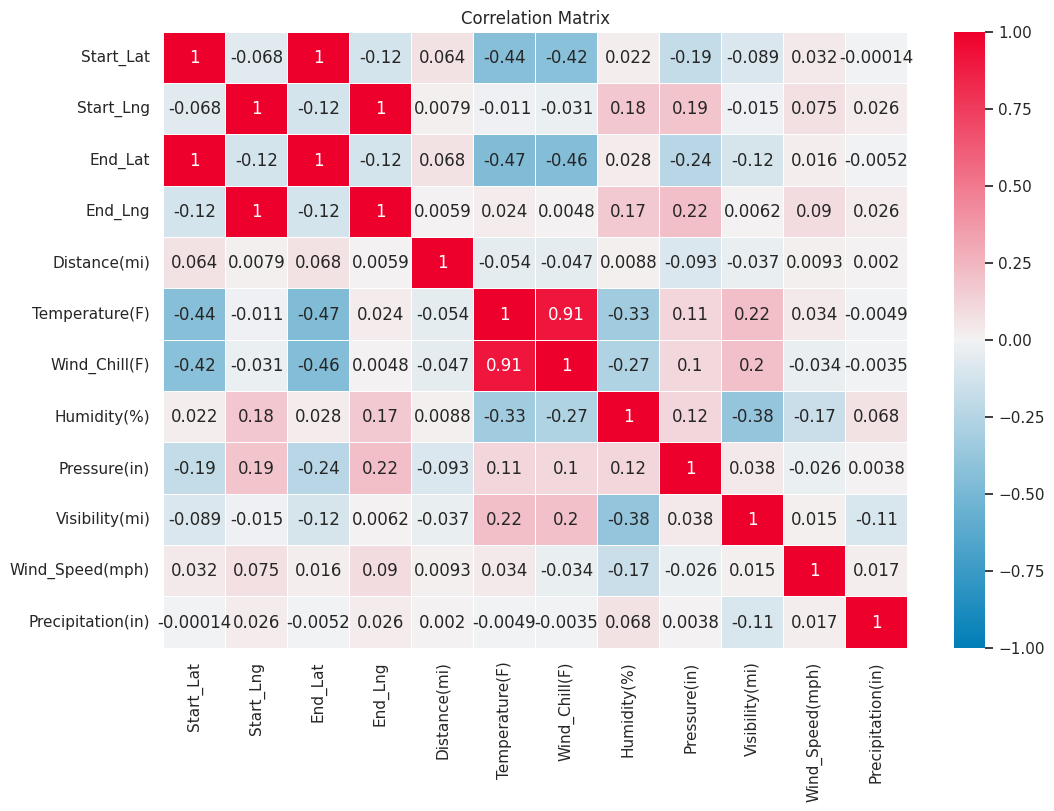

In [28]:
plt.figure(figsize=(12, 8))

cmap = sb.diverging_palette(
    h_neg=240,
    h_pos=10,
    s=100,
    as_cmap=True,
)

sb.heatmap(corr_matrix, annot=True, cmap=cmap, linewidths=0.5, center=0, vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()

## Análise de Variáveis Categórica

## Top 20 Temperaturas com mais acidentes
Analisando as 20 temperaturas com mais acidentes registrados, podemos perceber que temos uma grande concentração em dias com 64 Fahrenheit, o que seria cerca de 17 graus celsius.

Já o restante não demonstra uma correlação muito grande entre acidentes e outras temperaturas.

## Top 20 Temperaturas com Mais Acidentes

Ao analisar as 20 temperaturas associadas ao maior número de acidentes registrados, observamos uma concentração bem distribuida, sem muitos picos de números de acidentes em uma determinada temperatura.

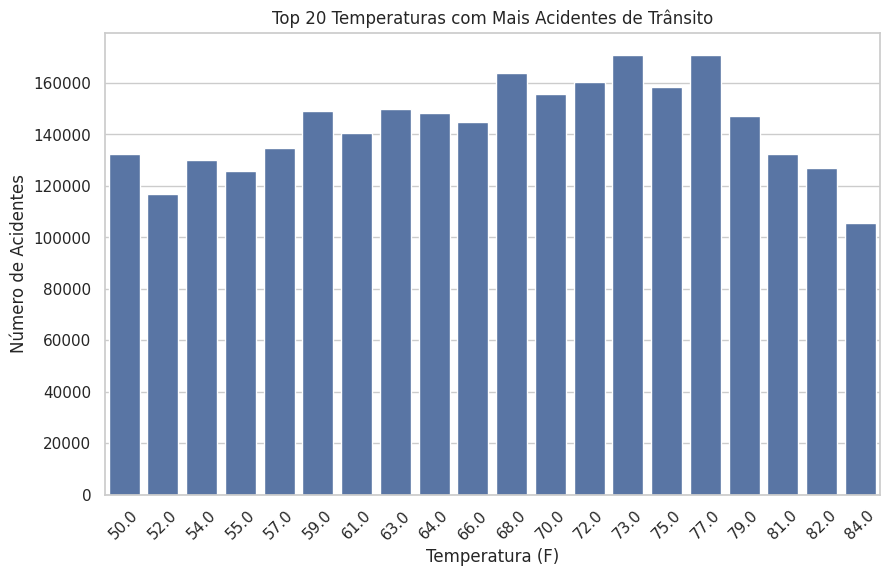

In [29]:
top_20_temps = df_parquet_pandas['Temperature(F)'].value_counts().nlargest(20)

top_20_temps_df = top_20_temps.reset_index()
top_20_temps_df.columns = ['Temperature(F)', 'Number of Accidents']

# 3. Criar o gráfico de barras
plt.figure(figsize=(10,6))
sb.barplot(data=top_20_temps_df, x='Temperature(F)', y='Number of Accidents')
plt.title('Top 20 Temperaturas com Mais Acidentes de Trânsito')
plt.xlabel('Temperatura (F)')
plt.ylabel('Número de Acidentes')
plt.xticks(rotation=45)  # Rotaciona os rótulos das temperaturas se necessário
plt.show()

## Top 10 Condições Climáticas com Mais Acidentes

Aproximadamente **35% dos acidentes** registrados ocorreram em condições climáticas favoráveis, incluindo dias muito nublados, nublados, limpos e parcialmente nublados, com porcentagens bastante semelhantes entre esses grupos, sem grandes destaques entre eles.

### Observações:

* É interessante notar que a maioria dos acidentes ocorre em dias com condições climáticas favoráveis. Isso pode indicar que as pessoas tendem a ficar mais desatentas ou relaxadas quando o clima está agradável, aumentando assim o risco de acidentes.

* Essa análise sugere que, embora o clima possa parecer seguro, a atenção e a cautela no trânsito devem ser mantidas independentemente das condições meteorológicas.

Esses achados ressaltam a importância de uma conscientização contínua sobre a segurança no trânsito, mesmo em dias que parecem favoráveis.

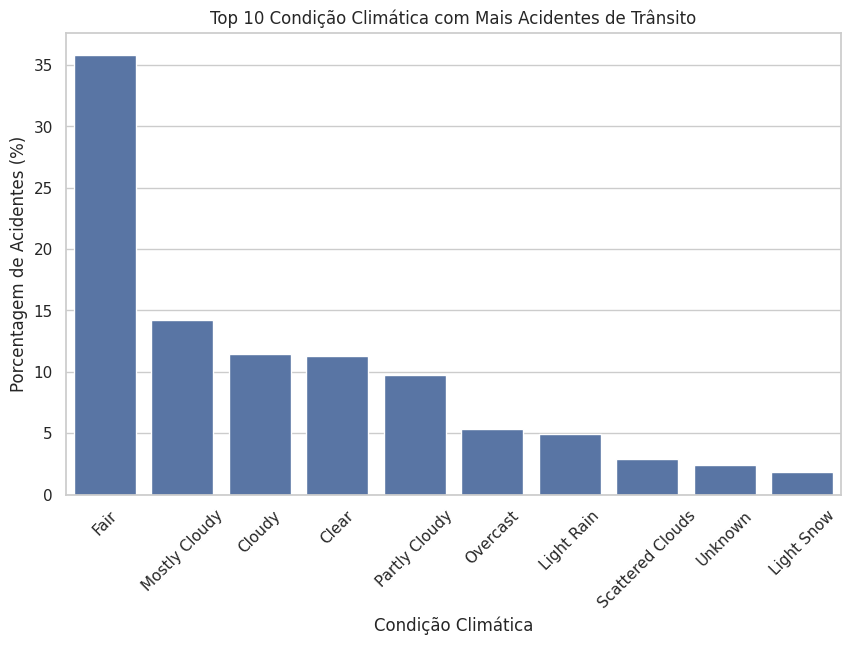

In [30]:
top_10_weather_condition_count = df_parquet_pandas['Weather_Condition'].value_counts().nlargest(10)

top_10_weather_condition_percentage = (top_10_weather_condition_count / top_10_weather_condition_count.sum()) * 100
top_10_weather_condition_percentage = top_10_weather_condition_percentage.sort_values(ascending=False)

top_10_weather_condition_percentage

top_10_weather_condition_df = top_10_weather_condition_percentage.reset_index()
top_10_weather_condition_df.columns = ['Weather_Condition', 'Percentage Number of Accidents']

plt.figure(figsize=(10,6))
sb.barplot(data=top_10_weather_condition_df, x='Weather_Condition', y='Percentage Number of Accidents')
plt.title('Top 10 Condição Climática com Mais Acidentes de Trânsito')
plt.xlabel('Condição Climática')
plt.ylabel('Porcentagem de Acidentes (%)')
plt.xticks(rotation=45)  # Rotaciona os rótulos das temperaturas se necessário
plt.show()

## Top 20 Cidades com Mais Acidentes

As cidades que lideram a lista de acidentes são **Miami**, **Houston** e **Los Angeles**, com números que variam entre **150.000** a **180.000 acidentes** registrados. No entanto, é notável que esses altos números diminuem drasticamente nas cidades seguintes, chegando à faixa de **50.000 acidentes** com **Columbia**, que ocupa a vigésima posição no ranking.

### Análise:

* **Concentração em Grandes Cidades**: A predominância de acidentes nas cidades mencionadas pode estar relacionada a fatores como densidade populacional, volume de tráfego e infraestrutura urbana.

* **Discrepância de Números**: A diferença significativa entre as cidades no topo da lista e as que estão nas posições inferiores sugere que, enquanto algumas cidades enfrentam problemas maiores relacionados à segurança no trânsito, outras podem ter estratégias mais eficazes de prevenção ou simplesmente menos tráfego.

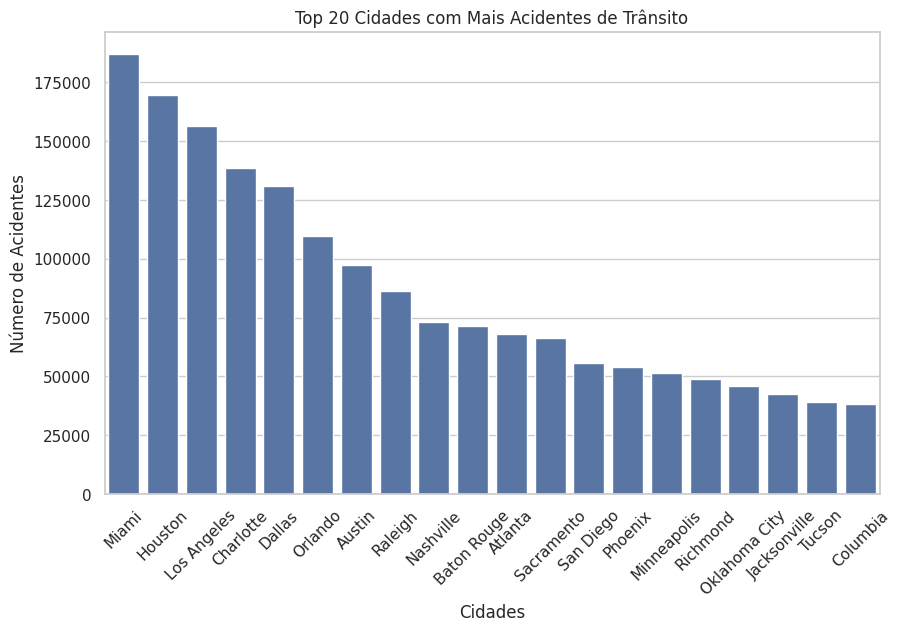

In [31]:
top_20_cities = df_parquet_pandas['City'].value_counts().nlargest(20)

top_20_cities_df = top_20_cities.reset_index()
top_20_cities_df.columns = ['City', 'Number of Accidents']

# 3. Criar o gráfico de barras
plt.figure(figsize=(10,6))
sb.barplot(data=top_20_cities_df, x='City', y='Number of Accidents')
plt.title('Top 20 Cidades com Mais Acidentes de Trânsito')
plt.xlabel('Cidades')
plt.ylabel('Número de Acidentes')
plt.xticks(rotation=45)
plt.show()

## Top 20 Estados com Mais Acidentes

Impressionantemente, quase **50%** dos acidentes nos Estados Unidos ocorrem no estado da **Califórnia**, seguido pela **Flórida** e **Texas**.

### Análise:

- **Concentração em Estados Populosos**: A alta incidência de acidentes nesses estados pode ser atribuída a fatores como a grande população, o volume intenso de tráfego e as extensas redes rodoviárias.
- **Comparação entre os Estados**: A predominância da Califórnia sugere que medidas específicas de segurança no trânsito podem ser necessárias para abordar a elevada taxa de acidentes nesse estado.

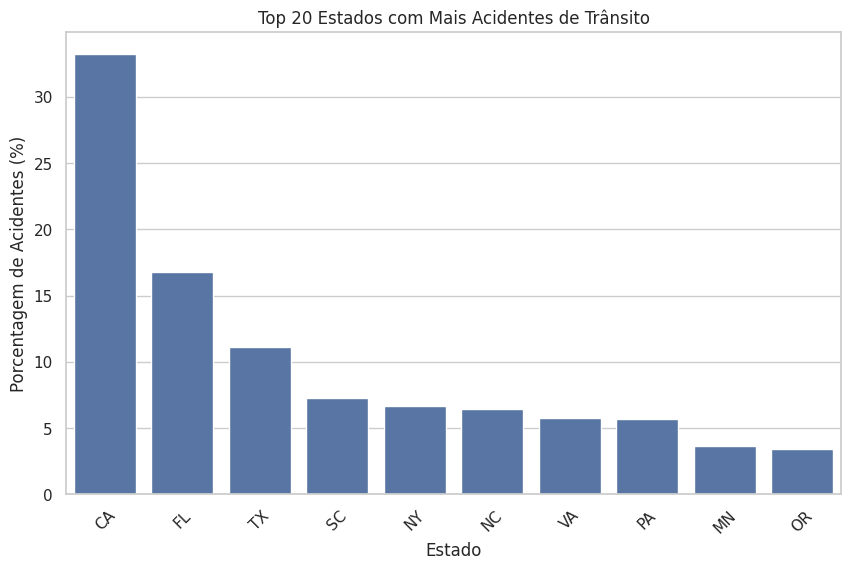

In [45]:
top_20_states_count = df_parquet_pandas['State'].value_counts().nlargest(10)

top_20_states_percentage = (top_20_states_count / top_20_states_count.sum()) * 100
top_20_states_percentage = top_20_states_percentage.sort_values(ascending=False)

top_20_states_percentage

top_20_states_df = top_20_states_percentage.reset_index()
top_20_states_df.columns = ['State', 'Percentage Number of Accidents']

plt.figure(figsize=(10,6))
sb.barplot(data=top_20_states_df, x='State', y='Percentage Number of Accidents')
plt.title('Top 20 Estados com Mais Acidentes de Trânsito')
plt.xlabel('Estado')
plt.ylabel('Porcentagem de Acidentes (%)')
plt.xticks(rotation=45)  # Rotaciona os rótulos das temperaturas se necessário
plt.show()

## Visualizações Interativas

Para proporcionar uma compreensão mais dinâmica dos dados sobre acidentes, utilizaremos gráficos interativos com a biblioteca **Plotly**. Isso inclui a criação de **mapas interativos** para mostrar a localização dos acidentes mais graves.

### Objetivos das Visualizações Interativas:

**Mapas Interativos**:
   * Visualizar a geolocalização dos acidentes, permitindo que os usuários explorem onde os incidentes mais graves ocorrem em diferentes estados ou cidades.

   * Usar marcadores para indicar a gravidade dos acidentes, com cores diferentes para representar diferentes níveis de severidade.


## Coluna: Severity

A coluna **Severity** é um indicador da gravidade dos acidentes, variando de 1 a 4, onde:

- **1**: Acidente menos grave
- **2**: Acidente de gravidade moderada
- **3**: Acidente grave
- **4**: Acidente mais grave

### Filtragem dos Dados

Considerado apenas registros com latitude e longitude registradas.

In [10]:
# Filtra apenas valores com latitue e longitude informadas
df_loc = df_parquet_pandas[(df_parquet_pandas['Start_Lat'].notnull()) & (df_parquet_pandas['Start_Lng'].notnull())]
df_loc

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7728389,A-1734952,Source2,2,2019-12-24 07:54:17,2019-12-24 08:52:00,40.504501,-82.219002,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
7728390,A-1734953,Source2,2,2019-12-24 08:05:25,2019-12-24 09:05:02,39.256283,-84.601654,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
7728391,A-1734954,Source2,2,2019-12-24 08:22:36,2019-12-24 09:22:21,40.398739,-83.391693,NaN,NaN,0.00,...,False,False,False,False,False,False,Day,Day,Day,Day
7728392,A-1734955,Source2,2,2019-12-24 08:57:50,2019-12-24 09:57:32,40.058830,-82.937469,NaN,NaN,0.00,...,False,False,False,False,True,False,Day,Day,Day,Day


## Agrupamento e Filtros de Localização

Nesta seção, realizaremos um agrupamento dos dados de acidentes com base na **gravidade** dos acidentes e sua **localização**.

Isso nos permitirá identificar padrões regionais e como a gravidade dos acidentes pode variar conforme a localização.


In [11]:
# Contar acidentes por localização (latitude e longitude)
location_counts = df_parquet_pandas.groupby(['Severity', 'Start_Lat', 'Start_Lng']).size().reset_index(name='Number of Accidents')

## Amostragem Aleatória de Localizações

Nesta célula, realizamos a amostragem de até 20.000 locais a partir do DataFrame `location_counts`, que contém informações sobre a gravidade dos acidentes em diferentes localizações.

O resultado, `sampled_locations`, é exibido para verificação, e essa amostra reduzida facilitará a visualização e análise de dados em etapas subsequentes.

In [12]:
sample_size = min(20000, len(location_counts))
sampled_locations = location_counts.sample(n=sample_size, random_state=42)
sampled_locations

,Severity,Start_Lat,Start_Lng,Number of Accidents
1651194,2,38.645687,-121.325157,1
2034885,2,40.640129,-73.681671,1
1965832,2,40.197336,-75.138310,1
2375726,2,43.086220,-77.402435,1
784020,2,33.831824,-117.114204,2
...,...,...,...,...
1152560,2,35.191700,-80.880501,14
1921275,2,40.033320,-76.304820,1
1291600,2,36.074019,-80.229855,3
1858001,2,39.773010,-86.025703,1


## Mapa Interativo com Plotly

Nesta célula, foi criado um mapa interativo utilizando a biblioteca Plotly Express (`px`) para visualizar a distribuição dos acidentes agrupados pela sua gravidade. O mapa destaca a localização dos acidentes nos Estados Unidos, permitindo uma análise espacial intuitiva.

- **Cores**: A gravidade dos acidentes é representada por uma escala de cores definida na lista `colors`, onde as cores variam de azul royal para verde claro, laranja e vermelho, indicando a severidade crescente dos acidentes.
  
- **Tamanho dos marcadores**: O tamanho dos pontos no mapa é proporcional ao número de acidentes em cada localização, o que permite identificar áreas com maior incidência de acidentes visualmente.

- **Interatividade**: Os dados são plotados em um mapa de fundo estilo 'carto-positron', e a interatividade permite que os usuários ampliem, desloquem e explorem as informações de forma dinâmica. Ao passar o mouse sobre um ponto, são exibidos detalhes como a severidade e o número de acidentes.

- **Configurações do gráfico**: O mapa é configurado com um zoom inicial de 3, focando a visualização em todo o território dos EUA. O gráfico também inclui um título centralizado que fornece contexto sobre a visualização.

Esse mapa interativo é útil para identificar padrões de acidentes e áreas críticas, permitindo a análise de dados em um formato visualmente atraente e informativo.

In [13]:
# Criar um mapa interativo com cores para severidade
colors = ["royalblue","lightseagreen","orange","red"]

fig = px.scatter_mapbox(
    sampled_locations,
    lat='Start_Lat',
    lon='Start_Lng',
    size='Number of Accidents',
    color='Severity',  # Usar a severidade como a coluna para cores
    color_continuous_scale=colors, # Escala de cores que destaca severidade
    size_max=15,
    hover_name='Number of Accidents',
    hover_data={'Severity': True, 'Number of Accidents': True},  # Adicionar severidade e número de acidentes ao hover
    mapbox_style='carto-positron',
    zoom=3,
    # center={"lat": 37.0902, "lon": -95.7129},
    height=600
)

# Adicionar título ao gráfico
fig.update_layout(
    title='Mapa Interativo de Acidentes de Trânsito nos EUA (Severidade 1 a 4)',
    title_x=0.5,
)

fig.show()

## Análise Temporal

Nesta seção, utilizaremos **heatmaps** para explorar a distribuição temporal dos acidentes de trânsito, visando identificar padrões de frequência em diferentes horários do dia e dias da semana.

### Objetivos da Análise

* **Identificar Horários de Pico**: Analisar os dados para descobrir em quais horários os acidentes ocorrem com mais frequência. Isso pode ajudar a entender os períodos de maior risco.

* **Analisar Dias da Semana**: Examinar a variação na frequência dos acidentes ao longo dos dias da semana, permitindo identificar quais dias apresentam maior incidência. Isso pode ser relevante para avaliar comportamentos relacionados ao tráfego e eventos específicos que podem impactar a segurança nas estradas.

### Metodologia

* **Coleta de Dados**: A análise será baseada nos dados de acidentes disponíveis, filtrando informações relevantes sobre o horário e o dia da semana em que cada acidente ocorreu.

* **Visualização com Heatmaps**: Utilizaremos heatmaps para representar visualmente as concentrações de acidentes, onde as cores mais quentes indicarão períodos de maior incidência. Isso proporcionará uma interpretação fácil e rápida dos dados, destacando os horários e dias que requerem mais atenção.

Esta análise temporal é crucial para a formulação de estratégias de segurança viária e pode fornecer insights valiosos para autoridades de transporte e planejamento urbano.

## Tratando Colunas de Datas

In [36]:
# Contar o número de acidentes para cada combinação de dia da semana e hora
df_parquet_pandas['Start_Time'] = pd.to_datetime(df_parquet_pandas['Start_Time'], format='ISO8601')

# Extrair o dia da semana (0=Segunda, 1=Terça, ..., 6=Domingo) e a hora
df_parquet_pandas['Day_of_Week'] = df_parquet_pandas['Start_Time'].dt.day_name()  # Nome do dia
df_parquet_pandas['Hour'] = df_parquet_pandas['Start_Time'].dt.hour

## Criando Dataframe de Frequência

Neste bloco de código, estamos preparando os dados para analisar a frequência de acidentes em relação aos dias da semana e às horas do dia.

As etapas realizadas incluem a contagem do número de acidentes por combinação de dia da semana e hora, além de reorganizar os dados em um formato apropriado para a visualização em um heatmap.

In [37]:
heatmap_data = df_parquet_pandas.groupby(['Day_of_Week', 'Hour']).size().reset_index(name='Number of Accidents')

heatmap_data_pivot = heatmap_data.pivot(index='Day_of_Week', columns='Hour', values='Number of Accidents').fillna(0)

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data_pivot = heatmap_data_pivot.reindex(ordered_days)

translation_dict = {
    'Monday': 'Segunda',
    'Tuesday': 'Terça',
    'Wednesday': 'Quarta',
    'Thursday': 'Quinta',
    'Friday': 'Sexta',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

heatmap_data_pivot = heatmap_data_pivot.rename(index=translation_dict)

In [38]:
heatmap_data_pivot

Hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
Day_of_Week,,,,,,,,,,,,,,,,,,,,,
Segunda,11138,9528,9430,9425,24562,35198,64415,93174,93223,52975,...,55598,68192,79013,79011,57312,37507,27515,21472,18668,13183
Terça,11959,9897,8819,8354,21767,34628,69807,107247,106998,58321,...,57048,71110,84588,86727,63058,39078,27944,21972,19274,14029
Quarta,12379,10587,9433,8595,22956,35193,69297,105292,104413,58461,...,58545,72453,85134,88225,64364,40644,29250,23034,20585,14630
Quinta,12740,11160,10087,9354,23621,34798,66272,100763,99383,56447,...,60426,74648,86677,88332,63697,41774,30138,24414,21514,14934
Sexta,13161,11493,10819,10144,26399,34382,59851,87055,86050,52552,...,68549,82739,92993,88661,68669,47319,33587,26782,23999,16751
Sábado,14330,12880,13596,10611,10936,11446,14746,17977,19209,23098,...,34900,32496,30882,28016,26862,23404,21086,20471,17873,14516
Domingo,13932,12788,13046,11177,11015,10982,13350,15364,15019,17142,...,28643,26831,26062,24219,23321,20896,18744,18135,15083,12389


## Heatmap

A análise do heatmap revela uma maior concentração de acidentes nos seguintes registros:

### Dia da Semana:
* **Segunda-feira a Sexta-feira**: Os acidentes são mais frequentes durante os dias úteis.

### Períodos:
* **6 a 8 horas da manhã**: Esse intervalo apresenta um pico significativo de ocorrências, possivelmente associado ao tráfego intenso do horário de pico.

* **14 até 18 horas da tarde**: Outro período crítico, onde muitos acidentes são registrados, possivelmente devido à combinação de tráfego de retorno para casa e a pressa do final do expediente.

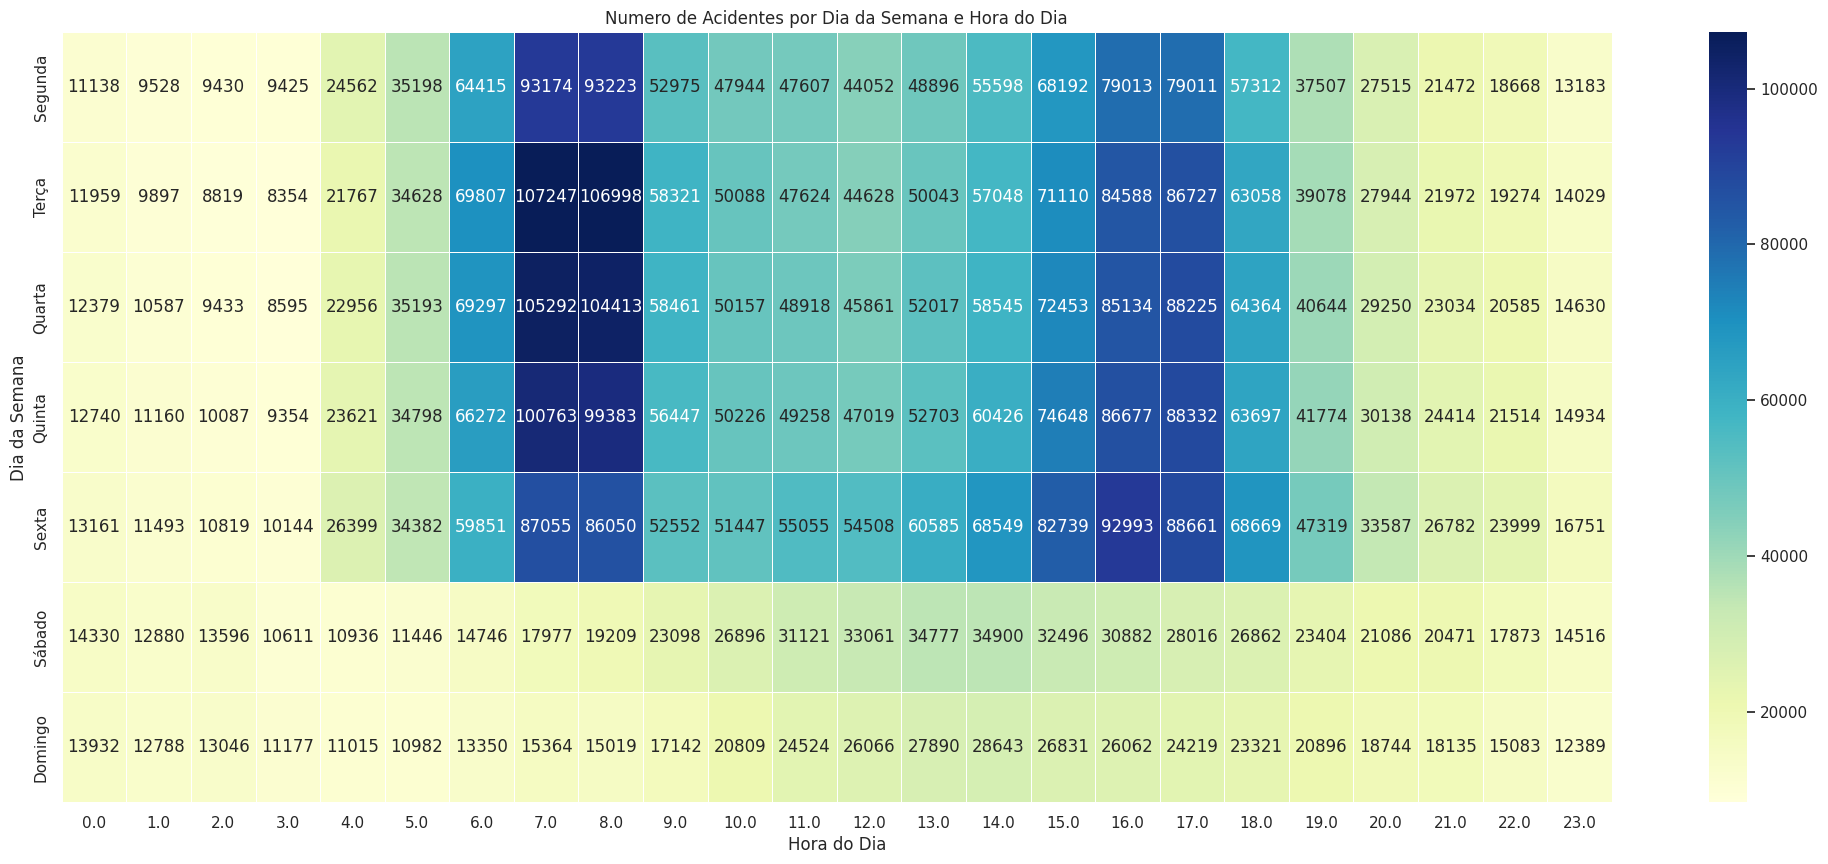

In [39]:
plt.figure(figsize=(25, 10))
sb.heatmap(heatmap_data_pivot, cmap='YlGnBu', annot=True, fmt=".0f", linewidths=.5)

# Configurações do gráfico
plt.title('Numero de Acidentes por Dia da Semana e Hora do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('Dia da Semana')
plt.xticks(rotation=0)  # Rotacionar os rótulos do eixo x se necessário
plt.show()

## Distribuição de Acidentes por Hora do Dia

Análise isolada da distribuição de acidentes ao longo do dia

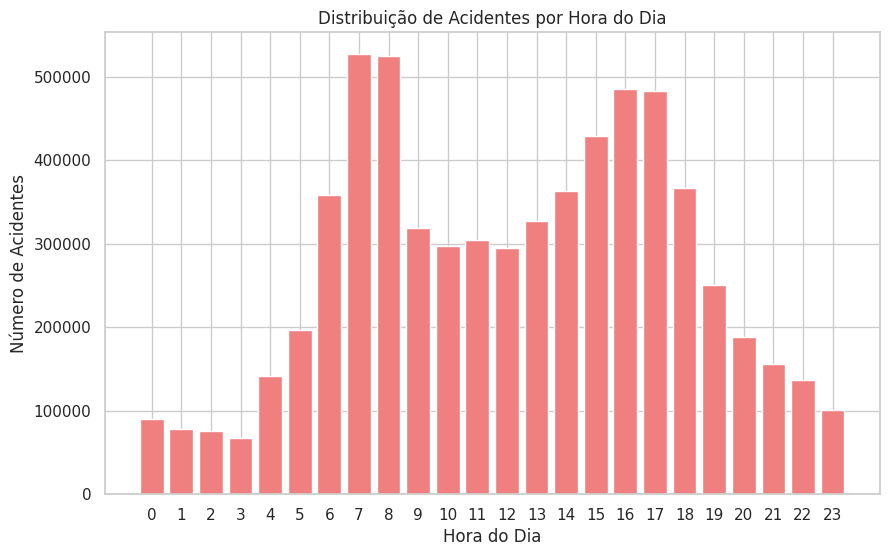

In [40]:
df_parquet_pandas['Hour'] = df_parquet_pandas['Start_Time'].dt.hour
accidents_by_hour = df_parquet_pandas.groupby('Hour').size().reset_index(name='Number of Accidents')

plt.figure(figsize=(10, 6))
plt.bar(accidents_by_hour['Hour'], accidents_by_hour['Number of Accidents'], color='lightcoral')
plt.title('Distribuição de Acidentes por Hora do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('Número de Acidentes')
plt.xticks(range(24))
plt.show()

## Distribuição de Acidentes por Dia da Semana

Análise isolada da distribuição de acidentes por Dia da Semana

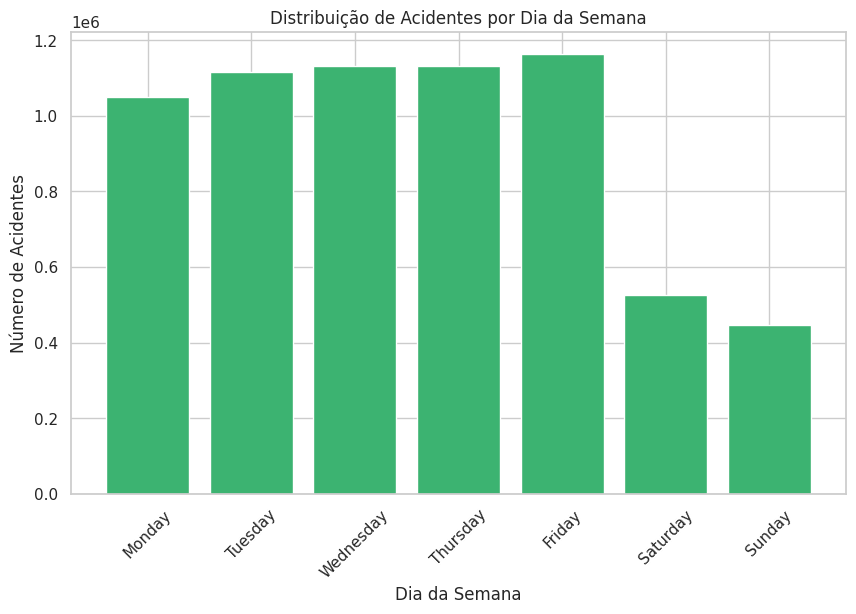

In [41]:
df_parquet_pandas['Day_of_Week'] = df_parquet_pandas['Start_Time'].dt.day_name()
accidents_by_day = df_parquet_pandas.groupby('Day_of_Week').size().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index(name='Number of Accidents')
translation_dict = {
    'Monday': 'Segunda',
    'Tuesday': 'Terça',
    'Wednesday': 'Quarta',
    'Thursday': 'Quinta',
    'Friday': 'Sexta',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

accidents_by_day = accidents_by_day.rename(index=translation_dict)

plt.figure(figsize=(10, 6))
plt.bar(accidents_by_day['Day_of_Week'], accidents_by_day['Number of Accidents'], color='mediumseagreen')
plt.title('Distribuição de Acidentes por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Número de Acidentes')
plt.xticks(rotation=45)
plt.show()

## Distribuição de Acidentes por Mês

A análise da distribuição de acidentes ao longo do ano revelou a presença de picos significativos nos meses de:

* **Novembro e Dezembro**: Este período, que inclui as festas de fim de ano, pode contribuir para um aumento nos acidentes devido ao aumento do tráfego e celebrações festivas.

* **Janeiro**: O início do ano, muitas vezes associado a comemorações de Ano Novo e férias prolongadas, também apresenta um aumento nos registros de acidentes.

Esses picos podem estar relacionados às datas comemorativas, que frequentemente resultam em um maior volume de veículos nas estradas, além de possíveis influências comportamentais dos motoristas durante essas épocas festivas.

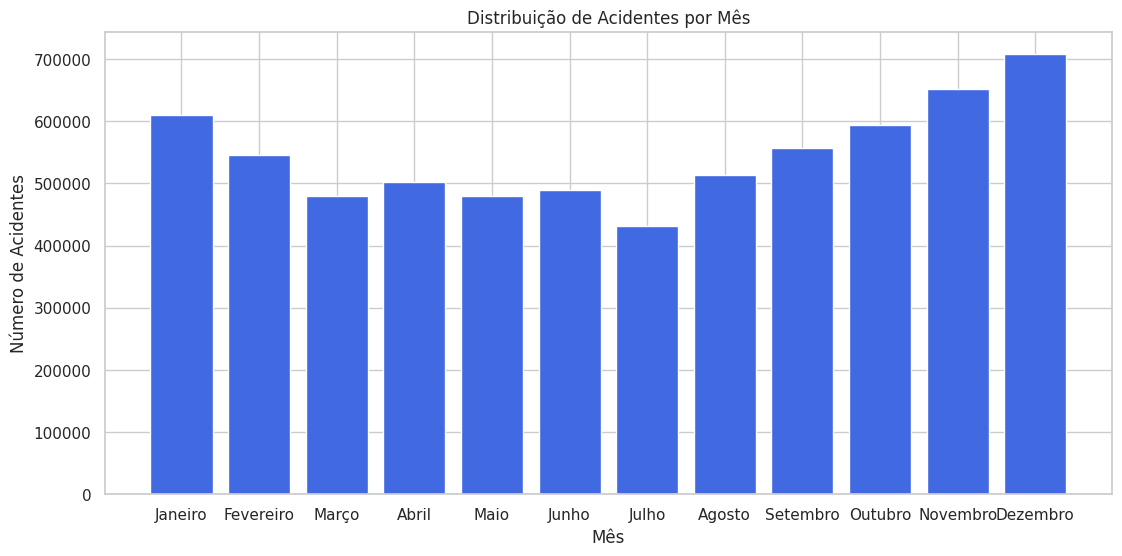

In [42]:
df_parquet_pandas['Month'] = df_parquet_pandas['Start_Time'].dt.month
accidents_by_month = df_parquet_pandas.groupby('Month').size().reset_index(name='Number of Accidents')
months_portuguese = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

plt.figure(figsize=(13, 6))
plt.bar(accidents_by_month['Month'], accidents_by_month['Number of Accidents'], color='royalblue')
plt.title('Distribuição de Acidentes por Mês')
plt.xlabel('Mês')
plt.ylabel('Número de Acidentes')
plt.xticks(ticks=range(1, 13), labels=months_portuguese)
plt.show()